In [1]:
################################################################################################################################
############################## PRACTICA ML: Jordi Ortega - IA2 #################################################################
################################################################################################################################

# 1. Entorno -> activamos venv, importamos librerías y cargamos el dataset
# 2. Train y Test Dataset -> Partimos el dataset en train y test
# 3. Data Cleaning -> Tratamos los valores nulos (entre otros: eliminación, sustitución estadística, variables nuevas)
#     3.1. bloque: id
#     3.2. bloque: url
#     3.3. bloque: piso_desc_texto_libre
#     3.4. bloque: propietario_desc
#     3.5. bloque: piso_desc
#     3.6. bloque: reviews
# 4. Correlación entr Variables -> Desplegamos matriz de correlación
# 5. Resumen Análisis Completo -> Se juntan los pasos en una única celda
# 6. Modelo a test -> Se aplica el modelo entrenado al dataset de test
# 7. Datos a Sklearn -> Preparamos los datos para la librería y aplicamos los modelo
# 8. Gradient Boosting Regressor -> Aplicamos el modelo
# 9. Selección variables y Modelo -> Seleccionamos variables, ajuste de hiperparámetros y relanzamos modelo

In [2]:
################################################################################################################################
############################## ENTORNO PRACTICA ################################################################################
################################################################################################################################
# Activamos el entorno virtual específico del proyecto desde Bash utilizando el comando source
# source /c/Users/JordiOrtega/023.keepcoding/ML/venv/Scripts/activate

# Verificamos que nuestro ipynb está el entorno correcto
import sys
print(sys.executable)

# Comprobamos desde Bash que requirements.txt ya ha sido instalado en venv
# pip freeze

# Importamos librerías principales
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Intregramos csv y miramos su volumetría
airbnb = pd.read_csv('./airbnb-listings-extract.csv', sep=';')
print(airbnb.shape)

C:\Users\JordiOrtega\023.keepcoding\ML\venv\Scripts\python.exe
(14780, 89)


In [3]:
################################################################################################################################
############################## TRAIN AND TEST DATASET ##########################################################################
################################################################################################################################

from sklearn.model_selection import train_test_split

# Dividimos el dataset en train y test
train, test = train_test_split(airbnb, test_size=0.2, shuffle=True, random_state=0)

print(f'Dimensiones del dataset de training: {train.shape}')
print(f'Dimensiones del dataset de test: {test.shape}')

# Guardamos físicamente los 2 datasets
train.to_csv('./airbnb-listings-extract_train.csv', sep=';', decimal='.', index=False)
test.to_csv('./airbnb-listings-extract_test.csv', sep=';', decimal='.', index=False)

# Cargamos el train y haremos el análisis exploratorio sobre él
airbnb_train = pd.read_csv('./airbnb-listings-extract_train.csv', sep=';', decimal='.')


Dimensiones del dataset de training: (11824, 89)
Dimensiones del dataset de test: (2956, 89)


In [4]:
################################################################################################################################
############################## DATA CLEANING ###################################################################################
################################################################################################################################

from unidecode import unidecode

# Observaciones genéricas: primeras rows, valores generales con describe() y conteo de nulos y palabras sin significado
#print(airbnb_train.head(1).T)
#print(airbnb_train.describe())
pd.set_option('display.max_rows', None)

# Lista de valores ocultos (sin mayuscula ni acentos) que pudieran esconder nulos
valores_ocultos = ['none', 'desconocido', 'unknown', 'sin datos', 'no disponible','ds', 'not available',
                   'vacio', 'n/a','na', 'sin informacion', 'no especificado', 'no relevante',
                   'sin respuesta', 'irrelevante', 'sin datos disponibles', 'sin contenido',
                   'null', 'no information', 'not specified', 'not relevant',
                   'no response', 'missing', 'empty', 'no data available']

# Creamos un DataFrame para almacenar los resultados
nulos_info = pd.DataFrame(columns=['Número de Nulos', 'Porcentaje Nulos'])

# Contamos nulos y valores ocultos por cada columna
def contar_nulos_y_ocultos(df, valores_ocultos, nulos_info):
    for col in airbnb_train.columns:
        nulos_mask = airbnb_train[col].isna()
        ocultos_mask = airbnb_train[col].astype(str).apply(lambda x: unidecode(x.lower()).strip()).isin(valores_ocultos)
        total_nulos = nulos_mask.sum()
        total_ocultos = ocultos_mask.sum()
        total_count = total_nulos + total_ocultos
        total_records = airbnb_train.shape[0]
        porcentaje_nulos = (total_count / total_records) * 100 if total_records > 0 else 0
        nulos_info.loc[col] = [total_count, porcentaje_nulos]

contar_nulos_y_ocultos(airbnb_train, valores_ocultos, nulos_info)

#print(nulos_info)

In [5]:
# Ordenamos las variables en bloques para determinar posibles acciones de 'cleaning' (rellenar nulos y conversión a numéricas): 
# Bloques: ids, url, piso_desc_texto_libre, propietario_desc, piso_desc, reviews

# Eliminamos registros específicos para simplificar el cleaning (analizado impacto en pruebas anteriores)
airbnb_train = airbnb_train.dropna(subset=['City', 'State', 'Zipcode', 'Market'])

# Configuramos pandas para mostrar hasta 1000 caracteres por columna
pd.set_option('display.max_colwidth', 1000)

# se excluyen variables con valores nulos o 'valores_ocultos' > 95% y variables objetivo
columnas_ocultas = ['Experiences Offered','Host Acceptance Rate','Square Feet','Has Availability','Jurisdiction Names','License'] 
airbnb_train = airbnb_train.drop(columnas_ocultas, axis=1)

variables_objetivo = ['Weekly Price','Monthly Price']
airbnb_train = airbnb_train.drop(variables_objetivo, axis=1)

In [6]:
# ------> bloque: ids (se consideran también como id las fechas que recojen la acción de scraping)
columnas_id = ['ID','Scrape ID','Last Scraped','Calendar last Scraped','Host ID'] 
airbnb_train = airbnb_train.drop(columnas_id, axis=1)

In [7]:
# ------> bloque: url
# Buscamos metadatos en las url, pero no parecen contener información útil.
columnas_url = ['Listing Url','Thumbnail Url','Medium Url','Picture Url','XL Picture Url','Host URL','Host Thumbnail Url','Host Picture Url']

# Convertiremos estas variables en 1 y 0 (para reflejar 'variable informada' o 'variable no informada')
for columna in columnas_url:
    airbnb_train[columna] = airbnb_train[columna].notna().astype(int)
    
print(airbnb_train[columnas_url].head(1))

   Listing Url  Thumbnail Url  Medium Url  Picture Url  XL Picture Url  \
0            1              1           1            1               1   

   Host URL  Host Thumbnail Url  Host Picture Url  
0         1                   1                 1  


In [8]:
# ------> bloque: piso_desc_texto_libre
# Revisamos el contenido de las variables de este bloque para decidir como tratar estas variables de texto libre.
# Con las variables de texto libre haremos 3 acciones:
#      1. detectar el idioma
#      2. contar carácteres
#      3. nube de palabras

In [9]:
# Importamos librería para detectar el idioma de los textos
from langdetect import detect

# lo hacemos sobre desciption (por no tener casi nulos y contener más texto, para los nulos en Description miramos en Name)
def detectar_idioma(row):
    try:
        if isinstance(row['Description'], str) and row['Description'].strip() != "":
            return detect(row['Description'])
        elif isinstance(row['Name'], str) and row['Name'].strip() != "":
            return detect(row['Name'])
        else:
            return 'desconocido_ajuste'
    except:
        return 'desconocido_ajuste'

# Aplicamos la función a cada fila del DataFrame
airbnb_train['detected_language'] = airbnb_train.apply(detectar_idioma, axis=1)

print(airbnb_train['detected_language'].head(5))


0    es
1    es
2    es
3    en
4    en
Name: detected_language, dtype: object


In [10]:
# Contamos carácteres de la variable Description
airbnb_train['description_char_count'] = airbnb_train['Description'].astype(str).str.len()
#print(airbnb_train[['Description', 'description_char_count']].head(5))

20 palabras más comunes:
Madrid: 5161
barrio: 2364
Plaza: 2116
restaurants: 1862
area: 1627
Sol: 1545
neighborhood: 1536
bars: 1478
minutes: 1435
mas: 1422
city: 1324
walk: 1299
zona: 1227
minutos: 1207
restaurantes: 1175
Puerta: 1149
shops: 1129
esta: 1105
apartment: 1073
Gran: 1025


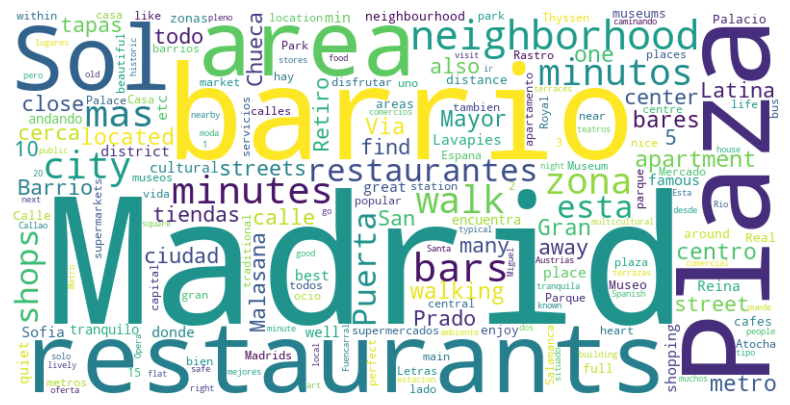

In [11]:

from collections import Counter
from wordcloud import WordCloud
import string

# Con la variable 'Neighborhood Overview' haremos una nube de palabras 
# para crearnos un flag que califique el registro como novedoso o no.
stop_words = set([
    # Stop words en español
    "el", "la", "un", "una", "los", "las", "en", "y", "de", "que", "a", 
    "es", "se", "por", "con", "para", "no", "lo", "su", "más", "este",
    "está", "tiene", "como", "me", "o", "del", "al", "una", "sus", "mi",
    "también", "muy", "entre", "ser", "sin", "sobre", "si", "cuando",
    
    # Stop words en inglés
    "i", "me", "my", "myself", "we", "our", "ours", "ourselves", 
    "you", "your", "yours", "yourself", "yourselves", "he", "him", 
    "his", "himself", "she", "her", "hers", "herself", "it", "its", 
    "itself", "they", "them", "their", "theirs", "themselves", 
    "what", "which", "who", "whom", "this", "that", "these", "those", 
    "am", "is", "are", "was", "were", "be", "been", "being", 
    "have", "has", "had", "having", "do", "does", "did", "doing", 
    "a", "an", "the", "and", "but", "if", "or", "because", "as", 
    "until", "while", "of", "at", "by", "for", "with", "about", 
    "against", "between", "into", "through", "during", "before", 
    "after", "above", "below", "to", "from", "up", "down", "in", 
    "out", "on", "off", "over", "under", "again", "further", 
    "then", "once", "here", "there", "when", "where", "why", 
    "how", "all", "any", "both", "each", "few", "more", "most", 
    "other", "some", "such", "no", "nor", "not", "only", "own", 
    "same", "so", "than", "too", "very", "s", "t", "can", "will", 
    "just", "don", "should", "now"
])

# Concatenamos todos los textos de la columna 'Neighborhood Overview', normalizamos y quitamos stop words
text = " ".join(
    airbnb_train['Neighborhood Overview']
    .dropna()
    .astype(str)
    .apply(unidecode)
)

text = text.translate(str.maketrans('', '', string.punctuation))
filtered_words = [word for word in text.split() if word.lower() not in stop_words]
word_counts = Counter(filtered_words)
most_common_words = word_counts.most_common(20)
print("20 palabras más comunes:")
for word, count in most_common_words:
    print(f"{word}: {count}")

# Creamos una nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)

# Mostramos la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [12]:
# Creamos una lista con las palabras comunes
top_words = ['madrid', 'barrio', 'plaza', 'restaurants', 'area', 
             'sol', 'neighborhood', 'bars', 'minutes', 'mas',
             'city', 'walk', 'zona', 'minutos', 'restaurantes',
             'shops', 'puerta', 'esta', 'apartment', 'centro']

def revisa_top_words(text):
    if pd.isna(text):
        return 2
    text = unidecode(str(text)).lower()
    for word in top_words:
        if word in text:
            return 0
    return 1

# Aplicamos la función a la columna 'Neighborhood Overview' y creamos la nueva columna 'original_lg'
airbnb_train['original_lg'] = airbnb_train['Neighborhood Overview'].apply(revisa_top_words)
#airbnb_train.head(10).T

In [13]:
# Eliminamos columnas
columnas_piso_desc_texto_libre = ['Name','Summary','Space','Description','Neighborhood Overview','Notes','Transit','Access','Interaction','House Rules'] 
airbnb_train = airbnb_train.drop(columnas_piso_desc_texto_libre, axis=1)

In [14]:
# ------> bloque: propietario_desc
# Usamos la variable Host Since para reportar el año de creacion
airbnb_train['enrollment_year'] = pd.to_datetime(airbnb_train['Host Since'],errors='coerce').apply(lambda x: 2024-x.year)
airbnb_train['enrollment_year'].fillna(airbnb_train['enrollment_year'].mode()[0], inplace=True)
#print(airbnb_train[['Host Since','enrollment_year']].head(20))

In [15]:
# Hacemos split de la columna 'Host Location'
def dividir_host_location(host_location):
    if pd.isna(host_location):
        return pd.Series([None, None, None])
    parts = host_location.split(',')
    while len(parts) < 3:
        parts.append(None)
    return pd.Series(parts[:3])

# Aplicamos la función y creamos las nuevas columnas
airbnb_train[['host_geo1', 'host_geo2', 'host_geo3']] = airbnb_train['Host Location'].apply(dividir_host_location)
# Eliminamos espacios en blanco de las nuevas columnas
airbnb_train['host_geo1'] = airbnb_train['host_geo1'].str.strip()
airbnb_train['host_geo2'] = airbnb_train['host_geo2'].str.strip()
airbnb_train['host_geo3'] = airbnb_train['host_geo3'].str.strip()
# Rellenamos nulos
airbnb_train['host_geo1'] = airbnb_train['host_geo1'].fillna('desconocido_ajuste')
airbnb_train['host_geo2'] = airbnb_train['host_geo2'].fillna('desconocido_ajuste')
airbnb_train['host_geo3'] = airbnb_train['host_geo3'].fillna('desconocido_ajuste')
airbnb_train['Host Neighbourhood'] = airbnb_train['Host Neighbourhood'].fillna('desconocido_ajuste')

In [16]:
# Convertimos estas variables en 1 y 0 (para reflejar 'variable informada' o 'variable no informada')
columnas_host = ['Host About']
for columna_h in columnas_host:
    airbnb_train[columna_h] = airbnb_train[columna_h].notna().astype(int)   
#print(airbnb_train[columnas_host].head(1))

In [17]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

# Creamos labelencoder y OrdinalEncoder (ambos métodos corren el riesgo de el algoritmo inteprete que el valor 2 es superior
# a 1...para las columnas más críticas haremos hot encoding). OrdinalEncoder previene de valores desconocidos en test.

oe_host_geo1 = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
oe_host_geo2 = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
oe_host_geo3 = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
oe_host_neighbourhood = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
airbnb_train['host_geo1'] = oe_host_geo1.fit_transform(airbnb_train[['host_geo1']])
airbnb_train['host_geo2'] = oe_host_geo2.fit_transform(airbnb_train[['host_geo2']])
airbnb_train['host_geo3'] = oe_host_geo3.fit_transform(airbnb_train[['host_geo3']])
airbnb_train['Host Neighbourhood'] = oe_host_neighbourhood.fit_transform(airbnb_train[['Host Neighbourhood']])

In [18]:
# Contamos verificaciones por registro
def count_verifications(verifications):
    if pd.isna(verifications):
        return 0
    return len(set(verifications.split(',')))

# Aplicamos la función y creamos una nueva columna 'verification_count'
airbnb_train['host_verification_count'] = airbnb_train['Host Verifications'].apply(count_verifications)

In [19]:
# Convertimos a númerica Host Response Time
for columna in ['Host Response Time']:
    print(f"Valores únicos en {columna}: {airbnb_train[columna].unique()}")
    
response_time_mapping = {
    'within an hour': 4,
    'within a few hours': 3,
    'within a day': 2,
    'a few days or more': 1,
    np.nan: 0  # O puedes dejar np.nan o usar otra estrategia para imputar
}

airbnb_train['Host Response Time'] = airbnb_train['Host Response Time'].map(response_time_mapping)
airbnb_train['Host Response Time'].fillna(0, inplace=True)

for columna in ['Host Response Time']:
    print(f"Valores únicos en {columna}: {airbnb_train[columna].unique()}")

Valores únicos en Host Response Time: ['within a few hours' 'within an hour' 'within a day' nan
 'a few days or more']
Valores únicos en Host Response Time: [3 4 2 0 1]


In [20]:
# Variables numéricas a las que ponemos 0 en lugar de nul
airbnb_train['Host Response Rate'] = airbnb_train['Host Response Rate'].fillna(0)
airbnb_train['Host Listings Count'] = airbnb_train['Host Listings Count'].fillna(0)
airbnb_train['Host Total Listings Count'] = airbnb_train['Host Total Listings Count'].fillna(0)
airbnb_train['Calculated host listings count'] = airbnb_train['Calculated host listings count'].fillna(0)

# Drop de variables
columnas_prop_desc = ['Host Name','Host Since','Host Location','Host Verifications'] 
airbnb_train = airbnb_train.drop(columnas_prop_desc, axis=1)

In [21]:
# ------> bloque: piso_desc
# Función para rellenar NaN en 'Neighbourhood' y 'Neighbourhood Group Cleansed' en base a 'Neighbourhood Cleansed'
def rellenar_nan(row, columna_a_rellenar, columna_referencia, df):
    if pd.isna(row[columna_a_rellenar]):
        if pd.isna(row[columna_referencia]):
            return 'desconocido_ajustado'
        referencia = df[df[columna_referencia] == row[columna_referencia]]
        valores_validos = referencia[columna_a_rellenar].dropna()
        if not valores_validos.empty:
            return valores_validos.iloc[0]
        else:
            return 'desconocido_ajustado'
    
    return row[columna_a_rellenar]

# Aplicamos la función
airbnb_train['Neighbourhood'] = airbnb_train.apply(rellenar_nan, axis=1, 
                               args=('Neighbourhood', 'Neighbourhood Cleansed', airbnb_train))

airbnb_train['Neighbourhood Group Cleansed'] = airbnb_train.apply(rellenar_nan, axis=1, 
                                              args=('Neighbourhood Group Cleansed', 'Neighbourhood Cleansed', airbnb_train))

nulos_neighbourhood = airbnb_train['Neighbourhood'].isnull().sum()
nulos_neigh_group = airbnb_train['Neighbourhood Group Cleansed'].isnull().sum()
print(nulos_neighbourhood)
print(nulos_neigh_group)
conteo_desconocido_neighbourhood = (airbnb_train['Neighbourhood'] == 'desconocido_ajustado').sum()
conteo_desconocido_neigh_group = (airbnb_train['Neighbourhood Group Cleansed'] == 'desconocido_ajustado').sum()
# Mostrar el resultado
print(f"Número de 'desconocido_ajustado' en 'Neighbourhood': {conteo_desconocido_neighbourhood}")
print(f"Número de 'desconocido_ajustado' en 'Neighbourhood Group Cleansed': {conteo_desconocido_neigh_group}")

0
0
Número de 'desconocido_ajustado' en 'Neighbourhood': 364
Número de 'desconocido_ajustado' en 'Neighbourhood Group Cleansed': 707


In [22]:
# Aunque podríamos haber ignorado la variable country y trabajar desde el code, el siguiente movimiento facilita la interpretación del dataset

def completar_paises(df):
    codigos_paises = df.dropna(subset=['Country']).drop_duplicates(subset=['Country Code']).set_index('Country Code')['Country'].to_dict()
    df['Country'] = df.apply(lambda row: codigos_paises.get(row['Country Code'], row['Country']) if pd.isna(row['Country']) else row['Country'], axis=1)

# Aplicamos la función
completar_paises(airbnb_train)

In [23]:
# Para las variables Property Type,Room Type y Bed Type aplicamos la moda
airbnb_train['Property Type'].fillna(airbnb_train['Property Type'].mode()[0], inplace=True)
airbnb_train['Room Type'].fillna(airbnb_train['Room Type'].mode()[0], inplace=True)
airbnb_train['Bed Type'].fillna(airbnb_train['Bed Type'].mode()[0], inplace=True)

# Aplicamos onehote para 'Room Type'
df_onehot_romm_type = pd.get_dummies(airbnb_train['Room Type'], prefix='room_type')

# Para Amenities nos quedamos con el conteo, si es nulo entenderemos que es 0
def count_amenities(amenities):
    if pd.isna(amenities):
        return 0
    return len(set(amenities.split(',')))

# Aplicamos la función
airbnb_train['amenities_count'] = airbnb_train['Amenities'].apply(count_amenities)
airbnb_train['amenities_count'].head()

# Para Features nos quedamos con el conteo, si es nulo entenderemos que es 0
def count_features(features):
    if pd.isna(features):
        return 0
    return len(set(features.split(',')))

# Aplicamos la función
airbnb_train['features_count'] = airbnb_train['Features'].apply(count_features)
airbnb_train['features_count'].head()

0    3
1    4
2    5
3    2
4    4
Name: features_count, dtype: int64

In [24]:
# Revisamos los valores únicos para ver magnitud
for columna in ['Calendar Updated']:
    print(f"Valores únicos en {columna}: {airbnb_train[columna].unique()}")

Valores únicos en Calendar Updated: ['2 weeks ago' 'today' 'a week ago' '3 days ago' '5 days ago'
 '3 weeks ago' '5 weeks ago' '4 days ago' 'yesterday' '12 months ago'
 'never' '13 months ago' '3 months ago' '4 months ago' '6 months ago'
 '6 days ago' '2 months ago' '4 weeks ago' '1 week ago' '9 months ago'
 '20 months ago' '8 months ago' '6 weeks ago' '2 days ago' '7 months ago'
 '17 months ago' '22 months ago' '5 months ago' '21 months ago'
 '10 months ago' '11 months ago' '24 months ago' '14 months ago'
 '7 weeks ago' '19 months ago' '16 months ago' '15 months ago'
 '23 months ago' '18 months ago' '35 months ago' '31 months ago'
 '30 months ago' '58 months ago' '37 months ago' '27 months ago'
 '48 months ago' '57 months ago' '29 months ago' '26 months ago'
 '33 months ago' '34 months ago' '52 months ago' '28 months ago'
 '25 months ago' '45 months ago' '51 months ago' '50 months ago']


In [25]:
# Aplicamos función para conversión a númerico
def transformar_calendar_updated(valor):
    if valor == 'today':
        return 0
    elif valor == 'a week ago':
        return 1
    elif valor == 'yesterday':
        return 0
    elif valor == 'never':
        return 53
    else:
        return int(valor.split()[0]) if valor.split()[0].isdigit() else None

# Aplicamos función
airbnb_train['calendar_updated_adjusted'] = airbnb_train['Calendar Updated'].apply(transformar_calendar_updated)

print(airbnb_train[['Calendar Updated', 'calendar_updated_adjusted']])

      Calendar Updated  calendar_updated_adjusted
0          2 weeks ago                          2
1                today                          0
2           a week ago                          1
3           3 days ago                          3
4           5 days ago                          5
5          3 weeks ago                          3
6          5 weeks ago                          5
7           3 days ago                          3
8                today                          0
9                today                          0
10          3 days ago                          3
11               today                          0
12         3 weeks ago                          3
13               today                          0
14          4 days ago                          4
15           yesterday                          0
16       12 months ago                         12
17          3 days ago                          3
18         2 weeks ago                          2


In [26]:
# Hacemos la medianda agrupada
airbnb_train['Bathrooms'] = airbnb_train.groupby('Accommodates')['Bathrooms'].transform(lambda x: x.fillna(x.median()))
airbnb_train['Bedrooms'] = airbnb_train.groupby('Accommodates')['Bedrooms'].transform(lambda x: x.fillna(x.median()))
airbnb_train['Beds'] = airbnb_train.groupby('Accommodates')['Beds'].transform(lambda x: x.fillna(x.median()))

# Asumimos que los nulos de 'Security Deposit' y 'Cleaning Fee' significan 0€
airbnb_train.loc[:, ['Security Deposit', 'Cleaning Fee', 'Availability 30', 'Availability 60', 'Availability 90', 'Availability 365']] = airbnb_train[['Security Deposit', 'Cleaning Fee', 'Availability 30', 'Availability 60', 'Availability 90', 'Availability 365']].fillna(0)

In [27]:
# Hacemos encoder en este bloque de variables
oe_neighbourhood = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
oe_neighbourhood_cleansed = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
oe_neighbourhood_group_cleansed = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
le_Country = LabelEncoder()
le_Country_Code = LabelEncoder()
oe_zipcode = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
oe_market = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
oe_property_type = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
le_Room_Type = LabelEncoder()
le_Bed_Type = LabelEncoder()
oe_smart_location = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

airbnb_train['Neighbourhood'] = oe_neighbourhood.fit_transform(airbnb_train[['Neighbourhood']])
airbnb_train['Neighbourhood Cleansed'] = oe_neighbourhood_cleansed.fit_transform(airbnb_train[['Neighbourhood Cleansed']])
airbnb_train['Neighbourhood Group Cleansed'] = oe_neighbourhood_group_cleansed.fit_transform(airbnb_train[['Neighbourhood Group Cleansed']])
airbnb_train['Country'] = le_Country.fit_transform(airbnb_train['Country'])
airbnb_train['Country Code'] = le_Country_Code.fit_transform(airbnb_train['Country Code'])
airbnb_train['Zipcode'] = oe_zipcode.fit_transform(airbnb_train[['Zipcode']])
airbnb_train['Market'] = oe_market.fit_transform(airbnb_train[['Market']])
airbnb_train['Property Type'] = oe_property_type.fit_transform(airbnb_train[['Property Type']])
airbnb_train['Smart Location'] = oe_smart_location.fit_transform(airbnb_train[['Smart Location']])
airbnb_train['Room Type'] = le_Room_Type.fit_transform(airbnb_train['Room Type'])
airbnb_train['Bed Type'] = le_Bed_Type.fit_transform(airbnb_train['Bed Type'])

In [28]:
# Aplicaremos onehot centrado en aquellos valores con más registros
frecuencia = airbnb_train['detected_language'].value_counts()
umbral_absoluto = 10
valores_frecuentes = frecuencia[frecuencia >= umbral_absoluto].index
airbnb_train['detected_language'] = airbnb_train['detected_language'].apply(lambda x: x if x in valores_frecuentes else 'otros')
conteo_final = airbnb_train['detected_language'].value_counts()
print(conteo_final)

# Generamos las variables dummy
airbnb_train = pd.get_dummies(airbnb_train, columns=['detected_language'], prefix='detected_language')

detected_language
en       5967
es       5168
fr         47
it         32
pt         25
otros      17
de         16
Name: count, dtype: int64


In [29]:
# Aplicaremos onehot centrado en aquellos valores con más registros
frecuencia = airbnb_train['City'].value_counts()
umbral_absoluto = 50
valores_frecuentes = frecuencia[frecuencia >= umbral_absoluto].index
airbnb_train['City'] = airbnb_train['City'].apply(lambda x: x if x in valores_frecuentes else 'otros')
conteo_final = airbnb_train['City'].value_counts()

# Generamos las variables dummy
airbnb_train = pd.get_dummies(airbnb_train, columns=['City'], prefix='city')

In [30]:
# Aplicaremos onehot centrado en aquellos valores con más registros
frecuencia = airbnb_train['State'].value_counts()
umbral_absoluto = 50
valores_frecuentes = frecuencia[frecuencia >= umbral_absoluto].index
airbnb_train['State'] = airbnb_train['State'].apply(lambda x: x if x in valores_frecuentes else 'otros')
conteo_final = airbnb_train['State'].value_counts()
print(conteo_final)  # Verifica el conteo final

# Generamos las variables dummy
airbnb_train = pd.get_dummies(airbnb_train, columns=['State'], prefix='state')

State
Comunidad de Madrid    8266
Community of Madrid    1354
Madrid                  539
otros                   511
Catalunya               150
Illes Balears           133
Balearic Islands        133
Île-de-France            83
NY                       53
CA                       50
Name: count, dtype: int64


In [31]:
# Generamos las variables dummy
airbnb_train = pd.get_dummies(airbnb_train, columns=['Cancellation Policy'], prefix='policy')

In [32]:
# ------> bloque: reviews
# Usamos la variable First Review and Last Review para reportar el año de creacion
airbnb_train['first_review'] = pd.to_datetime(airbnb_train['First Review']).apply(lambda x: 2024-x.year)
airbnb_train['last_review'] = pd.to_datetime(airbnb_train['Last Review']).apply(lambda x: 2024-x.year)

nan_reviews = airbnb_train[airbnb_train['Number of Reviews']==0]
coinciden_nan = nan_reviews[nan_reviews['First Review'].isna() & nan_reviews['Last Review'].isna()]
numero_de_casos = coinciden_nan.shape[0]
print(f"Número de casos donde 'Number of Reviews', 'First Review', y 'Last Review' son NaN: {numero_de_casos}")

# Asignamos a los nulos un valor predeterminado
airbnb_train['first_review'] = airbnb_train['first_review'].fillna(-1)
airbnb_train['last_review'] = airbnb_train['last_review'].fillna(-1)

Número de casos donde 'Number of Reviews', 'First Review', y 'Last Review' son NaN: 2370


In [33]:
# Para las reviews asumimos que puntua la gente muy contenta o muy enfada, por esto llenaremos nulls con la media
reviews_to_fill = ['Review Scores Rating', 'Review Scores Accuracy','Review Scores Cleanliness','Review Scores Checkin','Review Scores Communication','Review Scores Location','Review Scores Value','Reviews per Month']

for col in reviews_to_fill:
    airbnb_train[col].fillna(airbnb_train[col].mean(), inplace=True)

In [34]:
# drop de variables
columnas_piso_desc = ['Amenities','Features','Calendar Updated','Geolocation','Street','First Review','Last Review'] 
airbnb_train = airbnb_train.drop(columnas_piso_desc, axis=1)

In [35]:
bool_columns = [
    'city_Barcelona', 'city_London', 'city_Madrid', 'city_Paris', 'city_otros',
    'policy_flexible', 'policy_flexible_new', 'policy_moderate', 'policy_moderate_new',
    'policy_strict', 'policy_strict_new', 'policy_super_strict_30', 'policy_super_strict_60',
    'state_Balearic Islands', 'state_CA', 'state_Catalunya', 'state_Community of Madrid', 
    'state_Comunidad de Madrid', 'state_Illes Balears', 'state_Madrid',
    'state_NY', 'state_otros', 'state_Île-de-France', 'detected_language_de', 
    'detected_language_en', 'detected_language_es', 'detected_language_fr', 
    'detected_language_it', 'detected_language_otros', 'detected_language_pt'
]

# Convertimos todas las columnas booleanas en 0 y 1 (int)
airbnb_train[bool_columns] = airbnb_train[bool_columns].astype(int)

In [36]:
# Comprobamos de nuevo si hay valores nulos en nuestro dataset
pd.set_option('display.max_rows', None)

valores_ocultos = ['none', 'desconocido', 'unknown', 'sin datos', 'no disponible','ds', 'not available',
                   'vacio', 'n/a','na', 'sin informacion', 'no especificado', 'no relevante',
                   'sin respuesta', 'irrelevante', 'sin datos disponibles', 'sin contenido',
                   'null', 'no information', 'not specified', 'not relevant',
                   'no response', 'missing', 'empty', 'no data available']

nulos_info = pd.DataFrame(columns=['Número de Nulos', 'Porcentaje Nulos'])


for col in airbnb_train.columns:
    nulos_mask = airbnb_train[col].isna()
    ocultos_mask = airbnb_train[col].astype(str).apply(lambda x: unidecode(x.lower()).strip()).isin(valores_ocultos)
    total_nulos = nulos_mask.sum()
    total_ocultos = ocultos_mask.sum()
    total_count = total_nulos + total_ocultos
    total_records = airbnb_train.shape[0]
    porcentaje_nulos = (total_count / total_records) * 100 if total_records > 0 else 0
    nulos_info.loc[col] = [total_count, porcentaje_nulos]

print(nulos_info)

                                Número de Nulos  Porcentaje Nulos
Listing Url                                 0.0          0.000000
Thumbnail Url                               0.0          0.000000
Medium Url                                  0.0          0.000000
Picture Url                                 0.0          0.000000
XL Picture Url                              0.0          0.000000
Host URL                                    0.0          0.000000
Host About                                  0.0          0.000000
Host Response Time                          0.0          0.000000
Host Response Rate                          0.0          0.000000
Host Thumbnail Url                          0.0          0.000000
Host Picture Url                            0.0          0.000000
Host Neighbourhood                          0.0          0.000000
Host Listings Count                         0.0          0.000000
Host Total Listings Count                   0.0          0.000000
Neighbourh

In [37]:
# Eliminamos registros donde la variable objetivo es nula
airbnb_train = airbnb_train[airbnb_train['Price'].notna()]

In [38]:
# Comprobamos el formato de las variables
airbnb_train.dtypes

Listing Url                         int32
Thumbnail Url                       int32
Medium Url                          int32
Picture Url                         int32
XL Picture Url                      int32
Host URL                            int32
Host About                          int32
Host Response Time                  int64
Host Response Rate                float64
Host Thumbnail Url                  int32
Host Picture Url                    int32
Host Neighbourhood                float64
Host Listings Count               float64
Host Total Listings Count         float64
Neighbourhood                     float64
Neighbourhood Cleansed            float64
Neighbourhood Group Cleansed      float64
Zipcode                           float64
Market                            float64
Smart Location                    float64
Country Code                        int32
Country                             int32
Latitude                          float64
Longitude                         

In [39]:
################################################################################################################################
############################## CORRELACION ENTRE VARIABLES #####################################################################
################################################################################################################################

In [40]:
airbnb_train.corr()

,Listing Url,Thumbnail Url,Medium Url,Picture Url,XL Picture Url,Host URL,Host About,Host Response Time,Host Response Rate,Host Thumbnail Url,...,policy_flexible,policy_flexible_new,policy_moderate,policy_moderate_new,policy_strict,policy_strict_new,policy_super_strict_30,policy_super_strict_60,first_review,last_review
Listing Url,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Thumbnail Url,NaN,1.000000,1.000000,0.003849,1.000000,NaN,-0.024404,0.161966,0.091714,-8.060356e-03,...,0.042555,0.010198,0.025933,0.008557,-0.064914,0.003820,0.013437,-0.025690,0.021137,0.008996
Medium Url,NaN,1.000000,1.000000,0.003849,1.000000,NaN,-0.024404,0.161966,0.091714,-8.060356e-03,...,0.042555,0.010198,0.025933,0.008557,-0.064914,0.003820,0.013437,-0.025690,0.021137,0.008996
Picture Url,NaN,0.003849,0.003849,1.000000,0.003849,NaN,-0.009372,-0.008422,-0.004566,-6.347938e-04,...,-0.003414,0.001322,-0.015732,0.001556,0.017110,0.002010,0.001512,0.001797,-0.008576,-0.008529
XL Picture Url,NaN,1.000000,1.000000,0.003849,1.000000,NaN,-0.024404,0.161966,0.091714,-8.060356e-03,...,0.042555,0.010198,0.025933,0.008557,-0.064914,0.003820,0.013437,-0.025690,0.021137,0.008996
Host URL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Host About,NaN,-0.024404,-0.024404,-0.009372,-0.024404,NaN,1.000000,0.207680,0.196245,2.223400e-02,...,-0.231980,0.024962,0.037354,0.024720,0.172775,0.034338,0.028551,0.033934,0.222127,0.164953
Host Response Time,NaN,0.161966,0.161966,-0.008422,0.161966,NaN,0.207680,1.000000,0.895234,3.575415e-02,...,-0.286320,0.013432,0.086519,0.022806,0.183637,0.016451,0.025133,0.015554,0.332763,0.297023
Host Response Rate,NaN,0.091714,0.091714,-0.004566,0.091714,NaN,0.196245,0.895234,1.000000,3.920038e-02,...,-0.275363,0.007763,0.100631,0.016939,0.161962,0.021281,0.015566,0.008240,0.342354,0.306529
Host Thumbnail Url,NaN,-0.008060,-0.008060,-0.000635,-0.008060,NaN,0.022234,0.035754,0.039200,1.000000e+00,...,-0.024227,0.000555,0.010369,0.000653,0.013086,0.000844,0.000635,0.000754,0.030528,0.031266


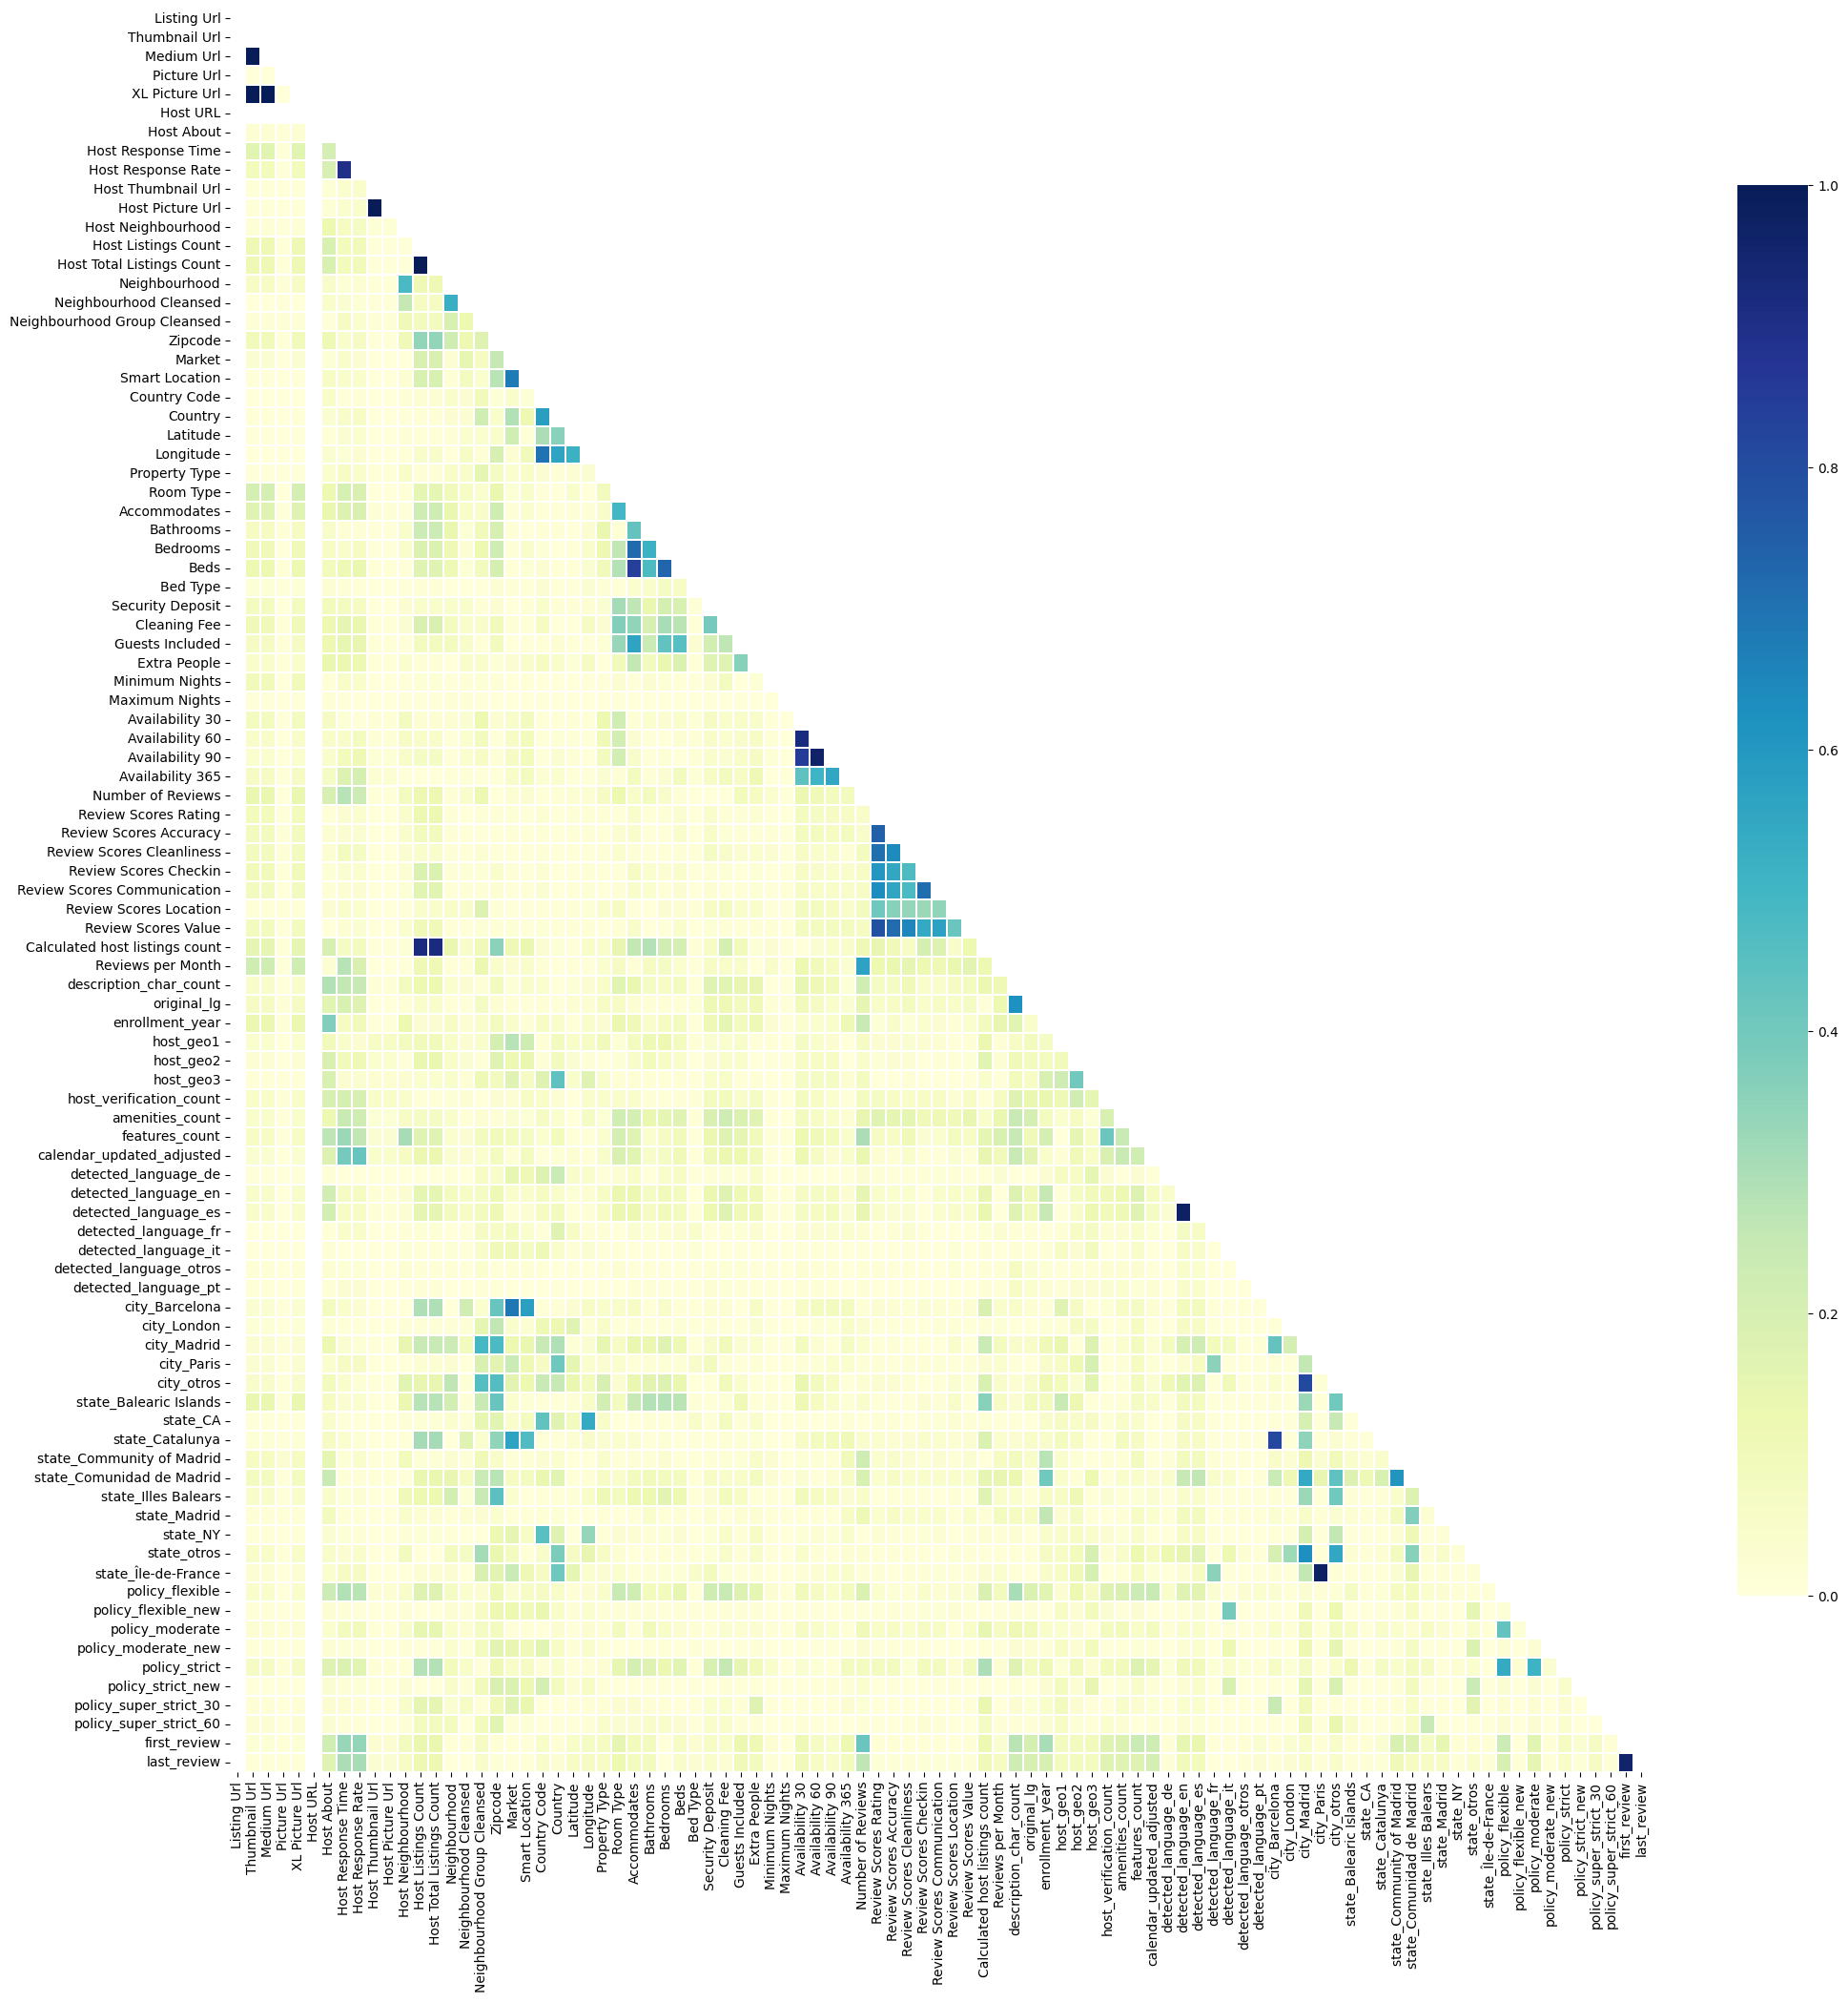

In [41]:
import seaborn as sns

# Pintamos la matriz de correlación de variables
corr = np.abs(airbnb_train.drop(['Price'], axis=1).corr())
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(24, 24))
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})
plt.show()

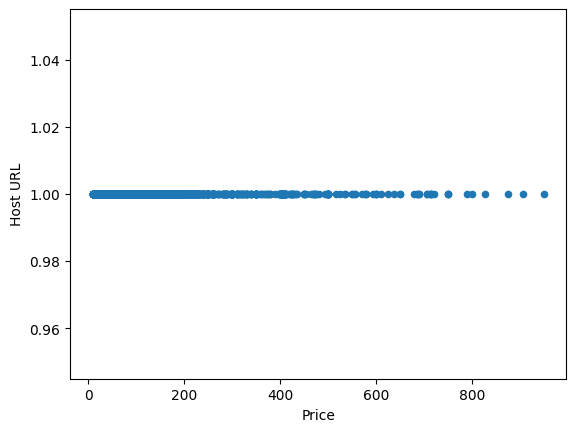

In [42]:
# PIntamos Host URL por confirmar que es totalmente independiente 
airbnb_train.plot(kind = 'scatter',x='Price',y = 'Host URL')
plt.xlabel('Price')
plt.ylabel('Host URL')
plt.show()

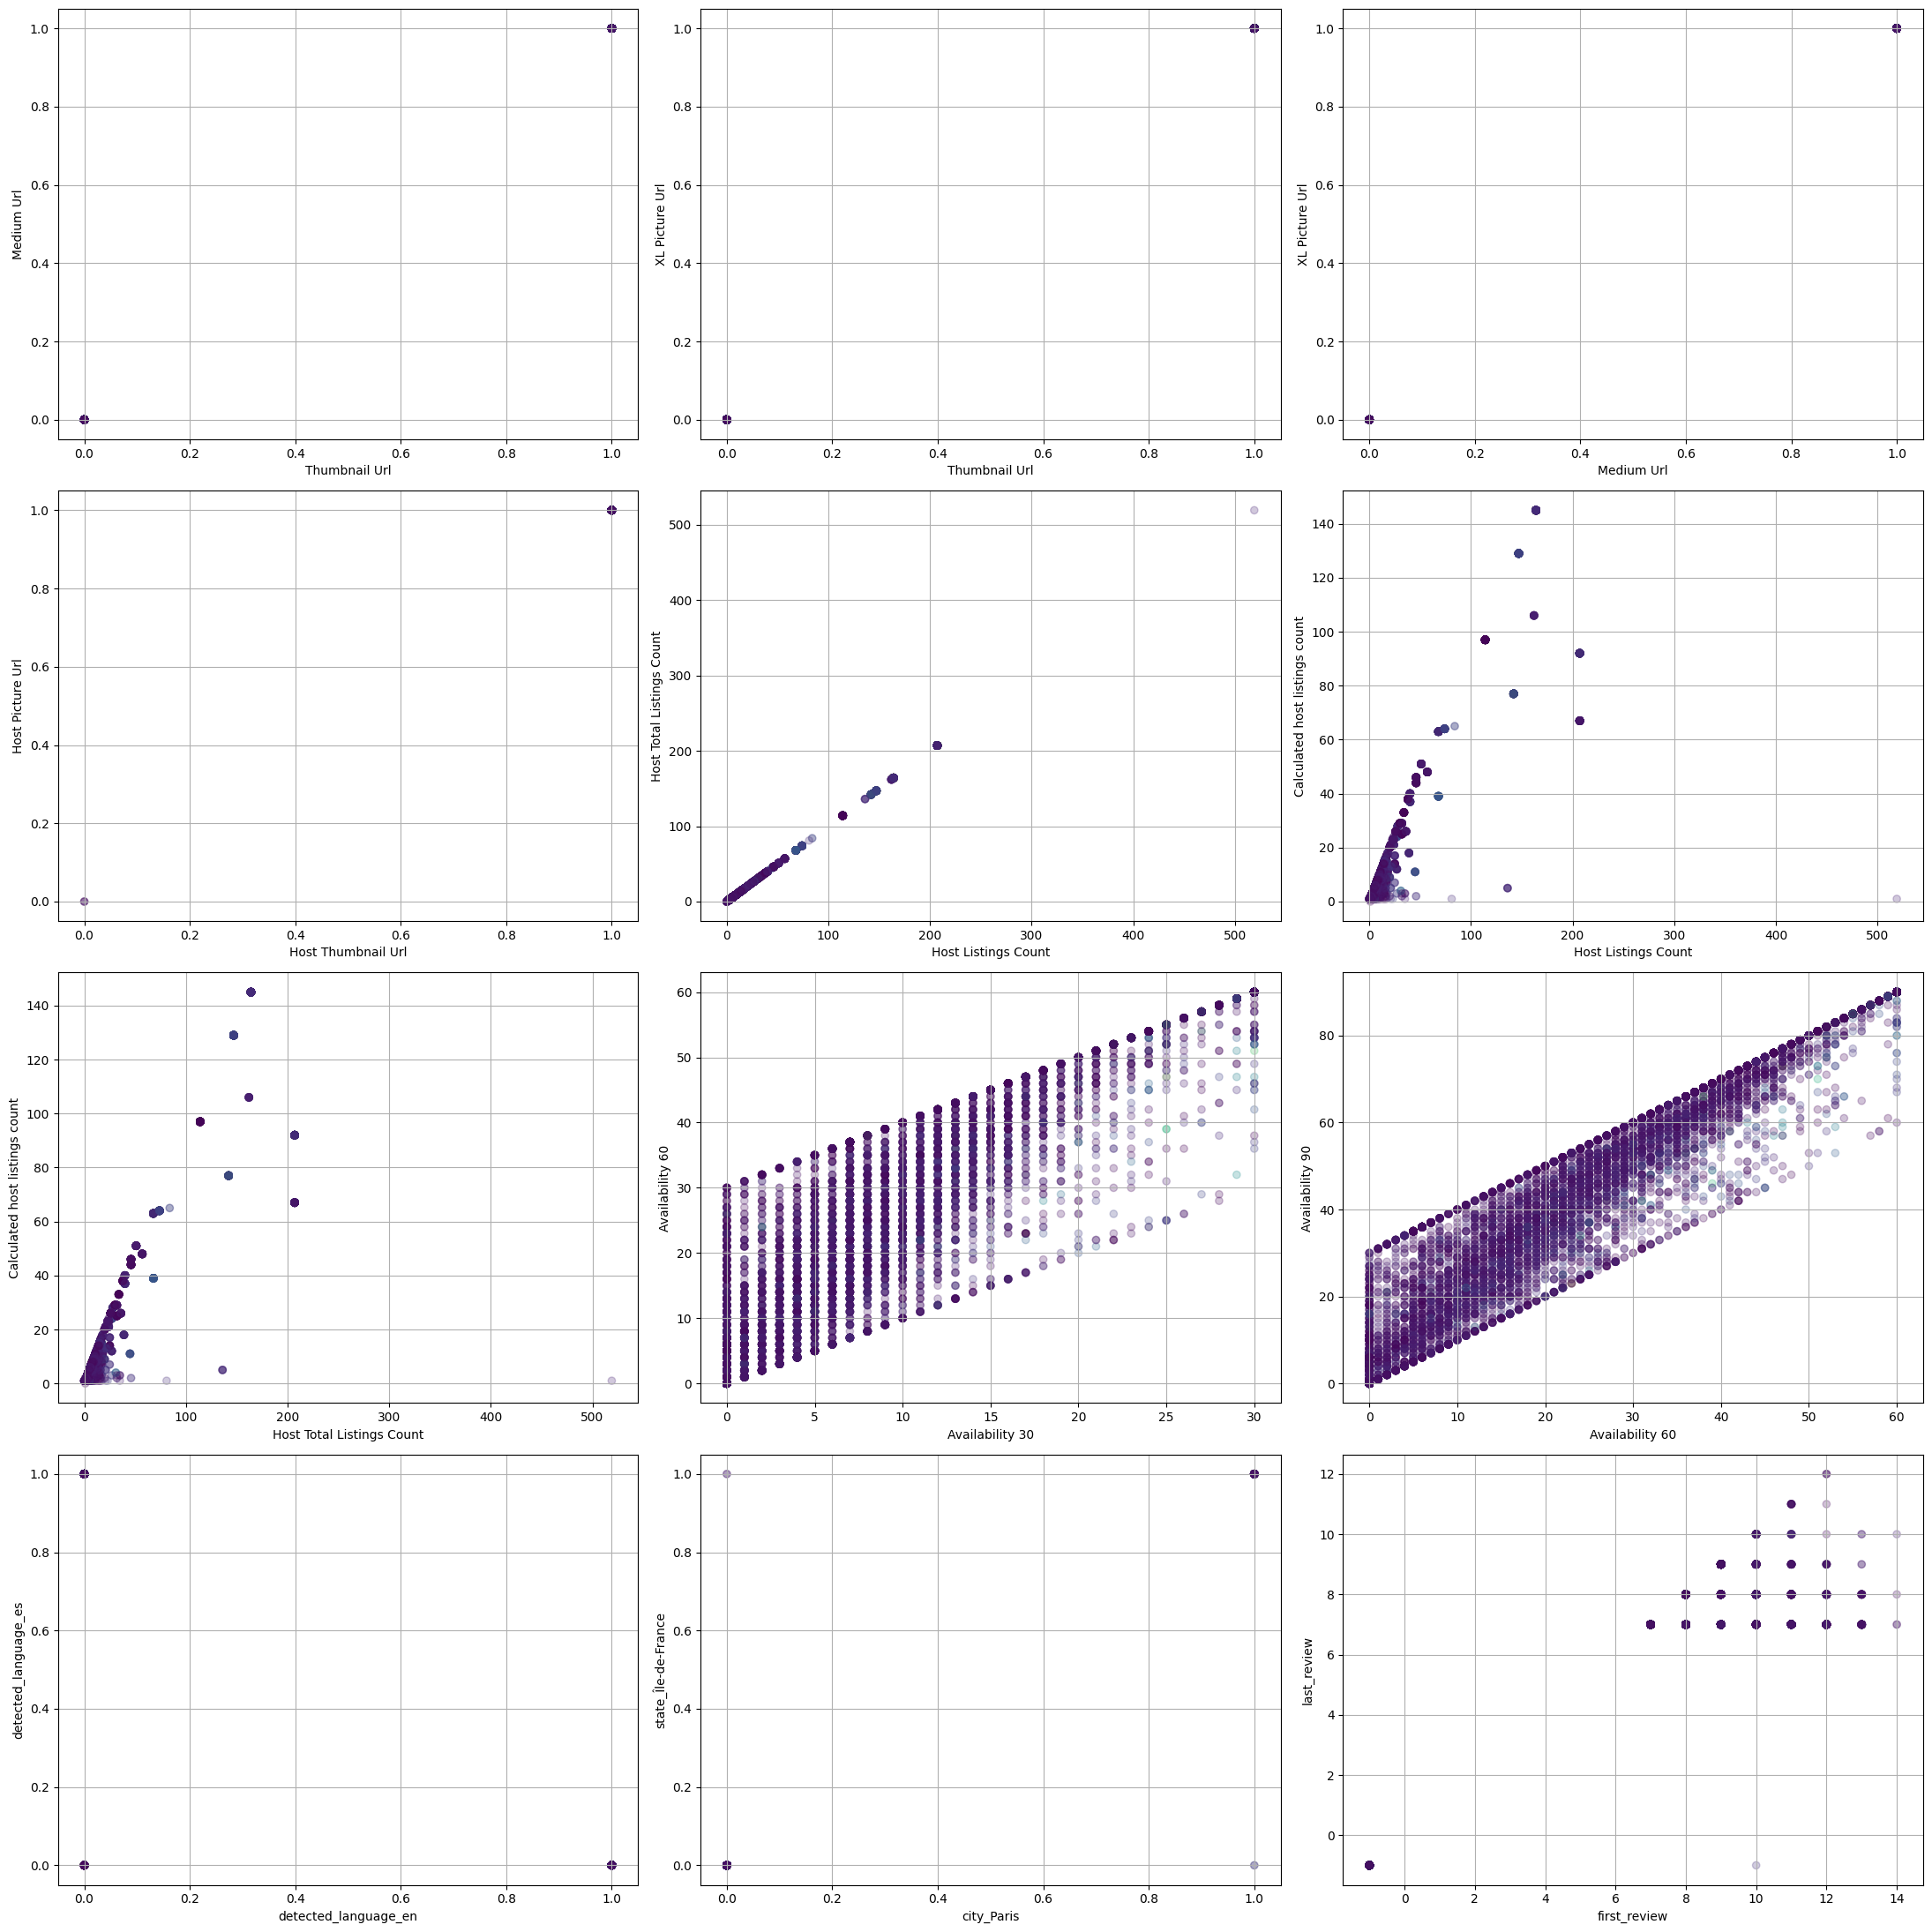

In [43]:
# Sobre la matriz de correlación, pintaremos aquellas variables con correlación mayor a 0.9
corr_matrix = airbnb_train.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
threshold = 0.9
pairs = np.where(upper>threshold)
fx = airbnb_train.columns[pairs[0]]
fy =  airbnb_train.columns[pairs[1]]

i=1
plt.figure(figsize=(22,22))
for f1,f2 in zip(fx,fy):
    
    plt.subplot(4,3,i)
    
    plt.scatter(airbnb_train[f1],airbnb_train[f2], c=airbnb_train['Price'], alpha=0.25)
    plt.xlabel(f1)
    plt.ylabel(f2)
    plt.grid()
    plt.tight_layout()
    
    i+=1
    
plt.show()

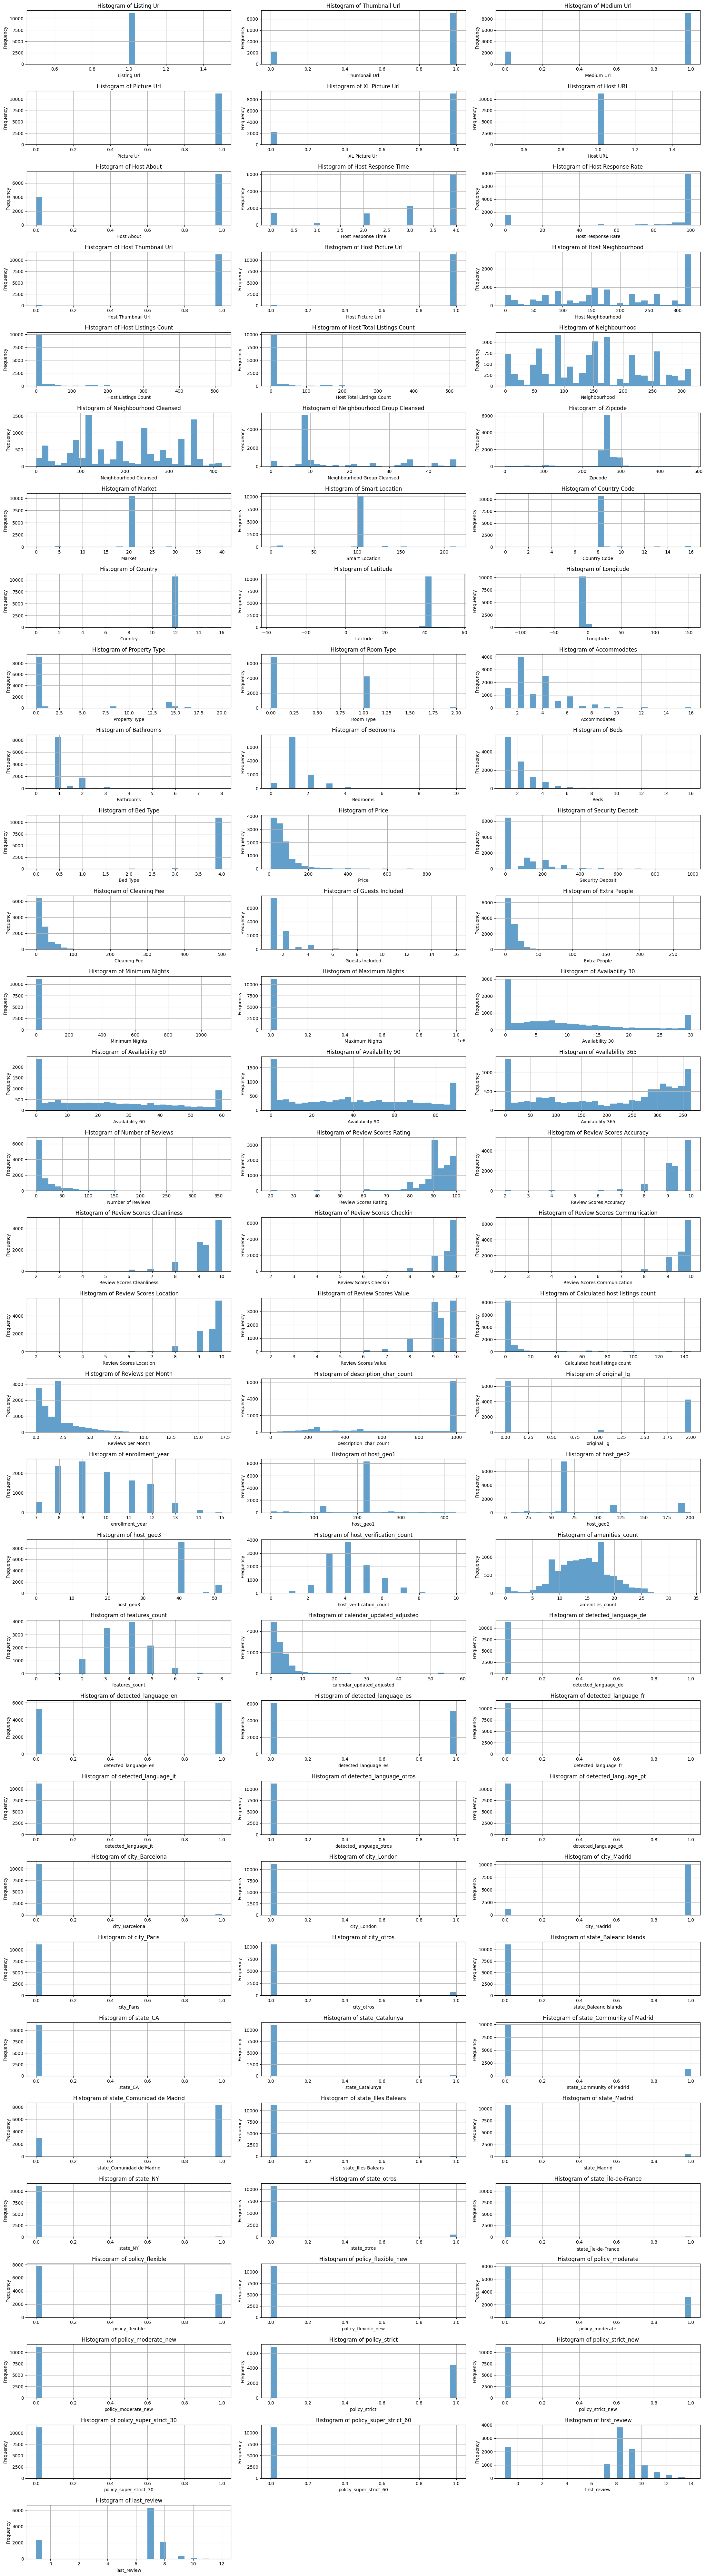

In [44]:
# Estudiamos la distribución de cada variable mediante histogramas

plt.figure(figsize=(22, 80))
num_columns = 3
num_rows = (len(airbnb_train.columns) + num_columns - 1) // num_columns


for i, column in enumerate(airbnb_train.columns):
    plt.subplot(num_rows, num_columns, i + 1)
    airbnb_train[column].plot.hist(alpha=0.7, bins=30, grid=True)
    plt.xlabel(column)
    plt.title(f'Histogram of {column}')

plt.tight_layout()
plt.show()

In [45]:
# Estudiamos la distribución de las variables según sus histogramas
# Aunque apreciamos alguna variable con distribución normal (no perfecta) como en el caso de amenities count,
# muchas otras variables no siguen una distribución gaussiana como por ejemplo:
# Neighboorhood Cleansed -> muestra que los datos estan agregados en categorías (no distribución continua y simétrica)
# City -> Distribución muy sesgada con un pico en una categoría
# Zipcode -> Aunque se aprecia un pico central, no sigue una forma simétrica esperada en la distribución normal

# Trabajaremos con el modelo xgboost por estar basado en arboles de decisión y ser menos sensible a distribuciones normales

In [46]:
# Eliminamos las siguientes variables por ser muy correlacionadas con otra variable
correlated_to_drop = ['Host URL', 'XL Picture Url', 'Thumbnail Url', 'Host Thumbnail Url','Host Total Listings Count','Calculated host listings count','Smart Location','Availability 60','first_review']
airbnb_train = airbnb_train.drop(correlated_to_drop, axis=1)

In [47]:
# Comprobamos que no hay nulos y pasamos al modelo
print(airbnb_train.isnull().sum())

Listing Url                     0
Medium Url                      0
Picture Url                     0
Host About                      0
Host Response Time              0
Host Response Rate              0
Host Picture Url                0
Host Neighbourhood              0
Host Listings Count             0
Neighbourhood                   0
Neighbourhood Cleansed          0
Neighbourhood Group Cleansed    0
Zipcode                         0
Market                          0
Country Code                    0
Country                         0
Latitude                        0
Longitude                       0
Property Type                   0
Room Type                       0
Accommodates                    0
Bathrooms                       0
Bedrooms                        0
Beds                            0
Bed Type                        0
Price                           0
Security Deposit                0
Cleaning Fee                    0
Guests Included                 0
Extra People  

In [48]:
################################################################################################################################
############################## RESUMEN ANÁLISIS COMPLETO #######################################################################
################################################################################################################################

In [49]:
# Combinamos todo el preprocesamiento en una única celda
airbnb_train = pd.read_csv('./airbnb-listings-extract_train.csv', sep=';', decimal='.')
airbnb_train = airbnb_train.drop(columnas_ocultas, axis=1)
airbnb_train = airbnb_train.drop(variables_objetivo, axis=1)

# ------> bloque: ids
airbnb_train = airbnb_train.drop(columnas_id, axis=1)

# ------> bloque: url                               
for columna in columnas_url:
    airbnb_train[columna] = airbnb_train[columna].notna().astype(int)                                 
airbnb_train = airbnb_train.dropna(subset=['City', 'State', 'Zipcode', 'Market'])

# ------> bloque: piso_desc_texto_libre
airbnb_train['detected_language'] = airbnb_train.apply(detectar_idioma, axis=1)
frecuencia = airbnb_train['detected_language'].value_counts()
umbral_absoluto = 10
valores_frecuentes = frecuencia[frecuencia >= umbral_absoluto].index
airbnb_train['detected_language'] = airbnb_train['detected_language'].apply(lambda x: x if x in valores_frecuentes else 'otros')
conteo_final = airbnb_train['detected_language'].value_counts()
airbnb_train = pd.get_dummies(airbnb_train, columns=['detected_language'], prefix='detected_language')
train_columns_detected_language = airbnb_train.columns[airbnb_train.columns.str.startswith('detected_language_')].tolist()
airbnb_train['description_char_count'] = airbnb_train['Description'].astype(str).str.len()
airbnb_train['original_lg'] = airbnb_train['Neighborhood Overview'].apply(revisa_top_words)                             
airbnb_train = airbnb_train.drop(columnas_piso_desc_texto_libre, axis=1)

# ------> bloque: propietario_desc
airbnb_train['enrollment_year'] = pd.to_datetime(airbnb_train['Host Since'],errors='coerce').apply(lambda x: 2024-x.year)
airbnb_train['enrollment_year'].fillna(airbnb_train['enrollment_year'].mode()[0], inplace=True)
airbnb_train[['host_geo1', 'host_geo2', 'host_geo3']] = airbnb_train['Host Location'].apply(dividir_host_location)
airbnb_train['host_geo1'] = airbnb_train['host_geo1'].str.strip()
airbnb_train['host_geo2'] = airbnb_train['host_geo2'].str.strip()
airbnb_train['host_geo3'] = airbnb_train['host_geo3'].str.strip()
airbnb_train['host_geo1'] = airbnb_train['host_geo1'].fillna('desconocido_ajuste')
airbnb_train['host_geo2'] = airbnb_train['host_geo2'].fillna('desconocido_ajuste')
airbnb_train['host_geo3'] = airbnb_train['host_geo3'].fillna('desconocido_ajuste')
airbnb_train['Host Neighbourhood'] = airbnb_train['Host Neighbourhood'].fillna('desconocido_ajuste')
columnas_host = ['Host About']
for columna_h in columnas_host:
    airbnb_train[columna_h] = airbnb_train[columna_h].notna().astype(int)
airbnb_train['host_geo1'] = oe_host_geo1.fit_transform(airbnb_train[['host_geo1']])
airbnb_train['host_geo2'] = oe_host_geo2.fit_transform(airbnb_train[['host_geo2']])
airbnb_train['host_geo3'] = oe_host_geo3.fit_transform(airbnb_train[['host_geo3']])
airbnb_train['Host Neighbourhood'] = oe_host_neighbourhood.fit_transform(airbnb_train[['Host Neighbourhood']])
airbnb_train['host_verification_count'] = airbnb_train['Host Verifications'].apply(count_verifications)
airbnb_train['Host Response Time'] = airbnb_train['Host Response Time'].map(response_time_mapping)
airbnb_train['Host Response Time'].fillna(0, inplace=True)
airbnb_train['Host Response Rate'] = airbnb_train['Host Response Rate'].fillna(0)
airbnb_train['Host Listings Count'] = airbnb_train['Host Listings Count'].fillna(0)
airbnb_train['Host Total Listings Count'] = airbnb_train['Host Total Listings Count'].fillna(0)
airbnb_train['Calculated host listings count'] = airbnb_train['Calculated host listings count'].fillna(0)
airbnb_train = airbnb_train.drop(columnas_prop_desc, axis=1)

# ------> bloque: piso_desc
airbnb_train['Neighbourhood'] = airbnb_train.apply(rellenar_nan, axis=1, args=('Neighbourhood', 'Neighbourhood Cleansed', airbnb_train))
airbnb_train['Neighbourhood Group Cleansed'] = airbnb_train.apply(rellenar_nan, axis=1, args=('Neighbourhood Group Cleansed', 'Neighbourhood Cleansed', airbnb_train))
completar_paises(airbnb_train)
airbnb_train['Property Type'].fillna(airbnb_train['Property Type'].mode()[0], inplace=True)
airbnb_train['Room Type'].fillna(airbnb_train['Room Type'].mode()[0], inplace=True)
airbnb_train['Bed Type'].fillna(airbnb_train['Bed Type'].mode()[0], inplace=True)
df_onehot_romm_type = pd.get_dummies(airbnb_train['Room Type'], prefix='room_type')
airbnb_train['amenities_count'] = airbnb_train['Amenities'].apply(count_amenities)
airbnb_train['features_count'] = airbnb_train['Features'].apply(count_features)
airbnb_train['calendar_updated_adjusted'] = airbnb_train['Calendar Updated'].apply(transformar_calendar_updated)
airbnb_train['Bathrooms'] = airbnb_train.groupby('Accommodates')['Bathrooms'].transform(lambda x: x.fillna(x.median()))
airbnb_train['Bedrooms'] = airbnb_train.groupby('Accommodates')['Bedrooms'].transform(lambda x: x.fillna(x.median()))
airbnb_train['Beds'] = airbnb_train.groupby('Accommodates')['Beds'].transform(lambda x: x.fillna(x.median()))
airbnb_train.loc[:, ['Security Deposit', 'Cleaning Fee', 'Availability 30', 'Availability 60', 'Availability 90', 'Availability 365']] = airbnb_train[['Security Deposit', 'Cleaning Fee', 'Availability 30', 'Availability 60', 'Availability 90', 'Availability 365']].fillna(0)
airbnb_train['Neighbourhood'] = oe_neighbourhood.fit_transform(airbnb_train[['Neighbourhood']])
airbnb_train['Neighbourhood Cleansed'] = oe_neighbourhood_cleansed.fit_transform(airbnb_train[['Neighbourhood Cleansed']])
airbnb_train['Neighbourhood Group Cleansed'] = oe_neighbourhood_group_cleansed.fit_transform(airbnb_train[['Neighbourhood Group Cleansed']])
airbnb_train['Country'] = le_Country.fit_transform(airbnb_train['Country'])
airbnb_train['Country Code'] = le_Country_Code.fit_transform(airbnb_train['Country Code'])
airbnb_train['Zipcode'] = oe_zipcode.fit_transform(airbnb_train[['Zipcode']])
airbnb_train['Market'] = oe_market.fit_transform(airbnb_train[['Market']])
airbnb_train['Property Type'] = oe_property_type.fit_transform(airbnb_train[['Property Type']])
airbnb_train['Room Type'] = le_Room_Type.fit_transform(airbnb_train['Room Type'])
airbnb_train['Bed Type'] = le_Bed_Type.fit_transform(airbnb_train['Bed Type'])
airbnb_train['Smart Location'] = oe_smart_location.fit_transform(airbnb_train[['Smart Location']])
frecuencia = airbnb_train['City'].value_counts()
umbral_absoluto = 50
valores_frecuentes = frecuencia[frecuencia >= umbral_absoluto].index
airbnb_train['City'] = airbnb_train['City'].apply(lambda x: x if x in valores_frecuentes else 'otros')
conteo_final = airbnb_train['City'].value_counts()
airbnb_train = pd.get_dummies(airbnb_train, columns=['City'], prefix='city')
train_columns_city = airbnb_train.columns[airbnb_train.columns.str.startswith('city_')].tolist()
frecuencia = airbnb_train['State'].value_counts()
umbral_absoluto = 50
valores_frecuentes = frecuencia[frecuencia >= umbral_absoluto].index
airbnb_train['State'] = airbnb_train['State'].apply(lambda x: x if x in valores_frecuentes else 'otros')
conteo_final = airbnb_train['State'].value_counts()
airbnb_train = pd.get_dummies(airbnb_train, columns=['State'], prefix='state')
train_columns_state = airbnb_train.columns[airbnb_train.columns.str.startswith('state_')].tolist()
airbnb_train = pd.get_dummies(airbnb_train, columns=['Cancellation Policy'], prefix='policy')
train_columns_policy = airbnb_train.columns[airbnb_train.columns.str.startswith('policy_')].tolist()

# ------> bloque: reviews
airbnb_train['first_review'] = pd.to_datetime(airbnb_train['First Review']).apply(lambda x: 2024-x.year)
airbnb_train['last_review'] = pd.to_datetime(airbnb_train['Last Review']).apply(lambda x: 2024-x.year)
airbnb_train['first_review'] = airbnb_train['first_review'].fillna(-1)
airbnb_train['last_review'] = airbnb_train['last_review'].fillna(-1)
for col in reviews_to_fill:
    airbnb_train[col].fillna(airbnb_train[col].mean(), inplace=True)
airbnb_train = airbnb_train.drop(columnas_piso_desc, axis=1)
airbnb_train[bool_columns] = airbnb_train[bool_columns].astype(int)
airbnb_train = airbnb_train.drop(correlated_to_drop, axis=1)
airbnb_train = airbnb_train[airbnb_train['Price'].notna()]

In [50]:
################################################################################################################################
############################## MODELO A TEST ###################################################################################
################################################################################################################################

In [51]:
# Aplicamos todo el preprocesamiento en una única celda a test

airbnb_test = pd.read_csv('./airbnb-listings-extract_test.csv', sep=';', decimal='.')
airbnb_test = airbnb_test.drop(columnas_ocultas, axis=1)
airbnb_test = airbnb_test.drop(variables_objetivo, axis=1)

# ------> bloque: ids
airbnb_test = airbnb_test.drop(columnas_id, axis=1)                                

# ------> bloque: url                               
for columna in columnas_url:
    airbnb_test[columna] = airbnb_test[columna].notna().astype(int)                                 
airbnb_test = airbnb_test.dropna(subset=['City', 'State', 'Zipcode', 'Market'])

# ------> bloque: piso_desc_texto_libre
airbnb_test['detected_language'] = airbnb_test.apply(detectar_idioma, axis=1)
airbnb_test['description_char_count'] = airbnb_test['Description'].astype(str).str.len()
airbnb_test['original_lg'] = airbnb_test['Neighborhood Overview'].apply(revisa_top_words)                             
airbnb_test = airbnb_test.drop(columnas_piso_desc_texto_libre, axis=1)

# ------> bloque: propietario_desc
airbnb_test['enrollment_year'] = pd.to_datetime(airbnb_test['Host Since'],errors='coerce').apply(lambda x: 2024-x.year)
airbnb_test['enrollment_year'].fillna(airbnb_train['enrollment_year'].mode()[0], inplace=True)
airbnb_test[['host_geo1', 'host_geo2', 'host_geo3']] = airbnb_test['Host Location'].apply(dividir_host_location)
airbnb_test['host_geo1'] = airbnb_test['host_geo1'].str.strip()
airbnb_test['host_geo2'] = airbnb_test['host_geo2'].str.strip()
airbnb_test['host_geo3'] = airbnb_test['host_geo3'].str.strip()
airbnb_test['host_geo1'] = airbnb_test['host_geo1'].fillna('desconocido_ajuste')
airbnb_test['host_geo2'] = airbnb_test['host_geo2'].fillna('desconocido_ajuste')
airbnb_test['host_geo3'] = airbnb_test['host_geo3'].fillna('desconocido_ajuste')
airbnb_test['Host Neighbourhood'] = airbnb_test['Host Neighbourhood'].fillna('desconocido_ajuste')
columnas_host = ['Host About']
for columna_h in columnas_host:
    airbnb_test[columna_h] = airbnb_test[columna_h].notna().astype(int)
airbnb_test['host_geo1'] = oe_host_geo1.transform(airbnb_test[['host_geo1']])
airbnb_test['host_geo2'] = oe_host_geo2.transform(airbnb_test[['host_geo2']])
airbnb_test['host_geo3'] = oe_host_geo3.transform(airbnb_test[['host_geo3']])
airbnb_test['Host Neighbourhood'] = oe_host_neighbourhood.transform(airbnb_test[['Host Neighbourhood']])
airbnb_test['host_verification_count'] = airbnb_test['Host Verifications'].apply(count_verifications)
airbnb_test['Host Response Time'] = airbnb_test['Host Response Time'].map(response_time_mapping)
airbnb_test['Host Response Time'].fillna(0, inplace=True)
airbnb_test['Host Response Rate'] = airbnb_test['Host Response Rate'].fillna(0)
airbnb_test['Host Listings Count'] = airbnb_test['Host Listings Count'].fillna(0)
airbnb_test['Host Total Listings Count'] = airbnb_test['Host Total Listings Count'].fillna(0)
airbnb_test['Calculated host listings count'] = airbnb_test['Calculated host listings count'].fillna(0)
airbnb_test = airbnb_test.drop(columnas_prop_desc, axis=1)

# ------> bloque: piso_desc
airbnb_test['Neighbourhood'] = airbnb_test.apply(rellenar_nan, axis=1, args=('Neighbourhood', 'Neighbourhood Cleansed', airbnb_train))
airbnb_test['Neighbourhood Group Cleansed'] = airbnb_test.apply(rellenar_nan, axis=1, args=('Neighbourhood Group Cleansed', 'Neighbourhood Cleansed', airbnb_train))
completar_paises(airbnb_test)
airbnb_test['Property Type'].fillna(airbnb_train['Property Type'].mode()[0], inplace=True)
airbnb_test['Room Type'].fillna(airbnb_train['Room Type'].mode()[0], inplace=True)
airbnb_test['Bed Type'].fillna(airbnb_train['Bed Type'].mode()[0], inplace=True)
airbnb_test['amenities_count'] = airbnb_test['Amenities'].apply(count_amenities)
airbnb_test['features_count'] = airbnb_test['Features'].apply(count_features)
airbnb_test['calendar_updated_adjusted'] = airbnb_test['Calendar Updated'].apply(transformar_calendar_updated)
bathrooms_median = airbnb_train.groupby('Accommodates')['Bathrooms'].median()
airbnb_test['Bathrooms'] = airbnb_test.apply(
    lambda row: bathrooms_median[row['Accommodates']] if pd.isna(row['Bathrooms']) else row['Bathrooms'],
    axis=1
)
bedroms_median = airbnb_train.groupby('Accommodates')['Bedrooms'].median()
airbnb_test['Bedrooms'] = airbnb_test.apply(
    lambda row: bedroms_median[row['Accommodates']] if pd.isna(row['Bedrooms']) else row['Bedrooms'],
    axis=1
)
beds_median = airbnb_train.groupby('Accommodates')['Beds'].median()
airbnb_test['Beds'] = airbnb_test.apply(
    lambda row: beds_median[row['Accommodates']] if pd.isna(row['Beds']) else row['Beds'],
    axis=1
)
airbnb_test.loc[:, ['Security Deposit', 'Cleaning Fee', 'Availability 30', 'Availability 60', 'Availability 90',
                    'Availability 365']] = airbnb_test[['Security Deposit', 'Cleaning Fee', 'Availability 30', 
                                                        'Availability 60', 'Availability 90', 'Availability 365']].fillna(0)
airbnb_test['Neighbourhood'] = oe_neighbourhood.transform(airbnb_test[['Neighbourhood']])
airbnb_test['Neighbourhood Cleansed'] = oe_neighbourhood_cleansed.transform(airbnb_test[['Neighbourhood Cleansed']])
airbnb_test['Neighbourhood Group Cleansed'] = oe_neighbourhood_group_cleansed.transform(airbnb_test[['Neighbourhood Group Cleansed']])
airbnb_test['Country'] = le_Country.transform(airbnb_test['Country'])
airbnb_test['Country Code'] = le_Country_Code.transform(airbnb_test['Country Code'])
airbnb_test['Zipcode'] = oe_zipcode.transform(airbnb_test[['Zipcode']])
airbnb_test['Market'] = oe_market.transform(airbnb_test[['Market']])
airbnb_test['Room Type'] = le_Room_Type.transform(airbnb_test['Room Type'])
airbnb_test['Bed Type'] = le_Bed_Type.transform(airbnb_test['Bed Type'])
airbnb_test['Property Type'] = oe_property_type.transform(airbnb_test[['Property Type']])
airbnb_test['Smart Location'] = oe_smart_location.transform(airbnb_test[['Smart Location']])
nuevas_columnas = [
    'detected_language_de', 'detected_language_en', 'detected_language_es', 
    'detected_language_fr', 'detected_language_it', 'detected_language_otros', 
    'detected_language_pt', 'city_Barcelona', 'city_London', 
    'city_Madrid', 'city_Paris', 'city_otros', 
    'state_Balearic Islands', 'state_CA', 'state_Catalunya', 
    'state_Community of Madrid', 'state_Comunidad de Madrid', 
     'state_Illes Balears', 'state_Madrid', 
    'state_NY', 'state_otros', 'state_Île-de-France', 
    'policy_flexible', 'policy_flexible_new', 
    'policy_moderate', 'policy_moderate_new', 
    'policy_strict', 'policy_strict_new', 
    'policy_super_strict_30', 'policy_super_strict_60'
]
for columna in nuevas_columnas:
    airbnb_test[columna] = 0
airbnb_test['detected_language_de'] = np.where(airbnb_test['detected_language'] == 'de', 1, 0)
airbnb_test['detected_language_en'] = np.where(airbnb_test['detected_language'] == 'en', 1, 0)
airbnb_test['detected_language_es'] = np.where(airbnb_test['detected_language'] == 'es', 1, 0)
airbnb_test['detected_language_fr'] = np.where(airbnb_test['detected_language'] == 'fr', 1, 0)
airbnb_test['detected_language_it'] = np.where(airbnb_test['detected_language'] == 'it', 1, 0)
airbnb_test['detected_language_otros'] = np.where(~airbnb_test['detected_language'].isin(['de', 'en', 'es', 'fr', 'it', 'pt']), 1, 0)
airbnb_test['detected_language_pt'] = np.where(airbnb_test['detected_language'] == 'pt', 1, 0)
airbnb_test['city_Barcelona'] = np.where(airbnb_test['City'] == 'Barcelona', 1, 0)
airbnb_test['city_London'] = np.where(airbnb_test['City'] == 'London', 1, 0)
airbnb_test['city_Madrid'] = np.where(airbnb_test['City'] == 'Madrid', 1, 0)
airbnb_test['city_Paris'] = np.where(airbnb_test['City'] == 'Paris', 1, 0)
airbnb_test['city_otros'] = np.where(~airbnb_test['City'].isin(['Barcelona', 'London', 'Madrid', 'Paris']), 1, 0)
airbnb_test['state_Balearic Islands'] = np.where(airbnb_test['State'] == 'Balearic Islands', 1, 0)
airbnb_test['state_CA'] = np.where(airbnb_test['State'] == 'CA', 1, 0)
airbnb_test['state_Catalunya'] = np.where(airbnb_test['State'] == 'Catalunya', 1, 0)
airbnb_test['state_Community of Madrid'] = np.where(airbnb_test['State'] == 'Community of Madrid', 1, 0)
airbnb_test['state_Comunidad de Madrid'] = np.where(airbnb_test['State'] == 'Comunidad de Madrid', 1, 0)
airbnb_test['state_Illes Balears'] = np.where(airbnb_test['State'] == 'Illes Balears', 1, 0)
airbnb_test['state_Madrid'] = np.where(airbnb_test['State'] == 'Madrid', 1, 0)
airbnb_test['state_NY'] = np.where(airbnb_test['State'] == 'NY', 1, 0)
airbnb_test['state_otros'] = np.where(~airbnb_test['State'].isin(['Balearic Islands', 'CA', 'Catalunya', 'Community of Madrid', 
                                                                   'Comunidad de Madrid', 'England', 'Illes Balears', 
                                                                   'Madrid', 'NY']), 1, 0)
airbnb_test['state_Île-de-France'] = np.where(airbnb_test['State'] == 'Île-de-France', 1, 0)
airbnb_test['policy_flexible'] = np.where(airbnb_test['Cancellation Policy'] == 'flexible', 1, 0)
airbnb_test['policy_flexible_new'] = np.where(airbnb_test['Cancellation Policy'] == 'flexible_new', 1, 0)
airbnb_test['policy_moderate'] = np.where(airbnb_test['Cancellation Policy'] == 'moderate', 1, 0)
airbnb_test['policy_moderate_new'] = np.where(airbnb_test['Cancellation Policy'] == 'moderate_new', 1, 0)
airbnb_test['policy_strict'] = np.where(airbnb_test['Cancellation Policy'] == 'strict', 1, 0)
airbnb_test['policy_strict_new'] = np.where(airbnb_test['Cancellation Policy'] == 'strict_new', 1, 0)
airbnb_test['policy_super_strict_30'] = np.where(airbnb_test['Cancellation Policy'] == 'super_strict_30', 1, 0)
airbnb_test['policy_super_strict_60'] = np.where(airbnb_test['Cancellation Policy'] == 'super_strict_60', 1, 0)

# ------> bloque: reviews
airbnb_test['first_review'] = pd.to_datetime(airbnb_test['First Review']).apply(lambda x: 2024-x.year)
airbnb_test['last_review'] = pd.to_datetime(airbnb_test['Last Review']).apply(lambda x: 2024-x.year)
airbnb_test['first_review'] = airbnb_test['first_review'].fillna(-1)
airbnb_test['last_review'] = airbnb_test['last_review'].fillna(-1)
for col in reviews_to_fill:
    airbnb_test[col].fillna(airbnb_train[col].mean(), inplace=True)
airbnb_test = airbnb_test.drop(columnas_piso_desc, axis=1)
airbnb_test = airbnb_test.drop(correlated_to_drop, axis=1)
airbnb_test.fillna(0, inplace=True)

In [52]:
print("Columnas después de cargar los datos:", airbnb_test.columns.tolist())

Columnas después de cargar los datos: ['Listing Url', 'Medium Url', 'Picture Url', 'Host About', 'Host Response Time', 'Host Response Rate', 'Host Picture Url', 'Host Neighbourhood', 'Host Listings Count', 'Neighbourhood', 'Neighbourhood Cleansed', 'Neighbourhood Group Cleansed', 'City', 'State', 'Zipcode', 'Market', 'Country Code', 'Country', 'Latitude', 'Longitude', 'Property Type', 'Room Type', 'Accommodates', 'Bathrooms', 'Bedrooms', 'Beds', 'Bed Type', 'Price', 'Security Deposit', 'Cleaning Fee', 'Guests Included', 'Extra People', 'Minimum Nights', 'Maximum Nights', 'Availability 30', 'Availability 90', 'Availability 365', 'Number of Reviews', 'Review Scores Rating', 'Review Scores Accuracy', 'Review Scores Cleanliness', 'Review Scores Checkin', 'Review Scores Communication', 'Review Scores Location', 'Review Scores Value', 'Cancellation Policy', 'Reviews per Month', 'detected_language', 'description_char_count', 'original_lg', 'enrollment_year', 'host_geo1', 'host_geo2', 'host_ge

In [53]:
airbnb_test = airbnb_test.drop(columns=['Cancellation Policy', 'detected_language', 'State', 'City'])

In [54]:
columns_train = set(airbnb_train.columns)
columns_test = set(airbnb_test.columns)

# Verifica si son iguales
same_columns = columns_train == columns_test

if same_columns:
    print("Los DataFrames tienen exactamente las mismas columnas.")
else:
    print("Los DataFrames NO tienen las mismas columnas.")

Los DataFrames tienen exactamente las mismas columnas.


In [55]:
missing_in_test = columns_train - columns_test
print("Columnas en train pero no en test:", missing_in_test)

# Columnas que están en test pero no en train
missing_in_train = columns_test - columns_train
print("Columnas en test pero no en train:", missing_in_train)

Columnas en train pero no en test: set()
Columnas en test pero no en train: set()


In [56]:
################################################################################################################################
############################## DATOS A SKLEARN #################################################################################
################################################################################################################################

In [57]:
airbnb_train.dtypes

Listing Url                       int32
Medium Url                        int32
Picture Url                       int32
Host About                        int32
Host Response Time                int64
Host Response Rate              float64
Host Picture Url                  int32
Host Neighbourhood              float64
Host Listings Count             float64
Neighbourhood                   float64
Neighbourhood Cleansed          float64
Neighbourhood Group Cleansed    float64
Zipcode                         float64
Market                          float64
Country Code                      int32
Country                           int32
Latitude                        float64
Longitude                       float64
Property Type                   float64
Room Type                         int32
Accommodates                      int64
Bathrooms                       float64
Bedrooms                        float64
Beds                            float64
Bed Type                          int32


In [58]:
# En un primer ejercicio se detectó que las variables más importantes eran las de la siguiente lista, como teníamos un problema
# de overfitting se ha deicido realizar un nuevo modelo focalizado en estas variables. Además para algunas de ellas
# se ha decidio aplicar un one hot.

columnas_simplificar  = ['Price',
    'Zipcode',
    'Latitude',
    'Longitude',
    'Room Type',
    'Accommodates',
    'Bathrooms',
    'Bedrooms',
    'Security Deposit',
    'Guests Included',
    'Maximum Nights',
    'Availability 30',
    'Availability 90',
    'detected_language_de',
    'detected_language_en',
    'detected_language_es',
    'detected_language_fr',
    'detected_language_it',
    'detected_language_otros',
    'detected_language_pt',
    'host_verification_count',
    'features_count',
    'city_Barcelona',
    'city_London',
    'city_Madrid',
    'city_Paris',
    'city_otros',
    'state_Balearic Islands',
    'state_CA',
    'state_Catalunya',
    'state_Community of Madrid',
    'state_Comunidad de Madrid',
    'state_Illes Balears',
    'state_Madrid',
    'state_NY',
    'state_otros',
    'state_Île-de-France',
    'policy_flexible',
    'policy_flexible_new',
    'policy_moderate',
    'policy_moderate_new',
    'policy_strict',
    'policy_strict_new',
    'policy_super_strict_30',
    'policy_super_strict_60']

airbnb_train = airbnb_train[columnas_simplificar]
airbnb_test = airbnb_test[columnas_simplificar]

In [59]:
price_position = airbnb_train.columns.get_loc('Price')
print(f"La posición de 'Price' es: {price_position}")

La posición de 'Price' es: 0


In [60]:
price_position = airbnb_test.columns.get_loc('Price')
print(f"La posición de 'Price' en test es: {price_position}")

La posición de 'Price' en test es: 0


In [61]:
from sklearn import preprocessing

# Preparamos los datos para aplicar CV
# Dataset de train
airbnb_train = airbnb_train.values
y_train = airbnb_train[:, 0]    
X_train = airbnb_train[:, 1:]     

# Dataset de test
airbnb_test = airbnb_test.values
y_test = airbnb_test[:, 0] 
X_test = airbnb_test[:, 1:]     

# Escalamos (con los datos de train)
scaler = preprocessing.StandardScaler().fit(X_train)
XtrainScaled = scaler.transform(X_train)
XtestScaled = scaler.transform(X_test)

print('Datos entrenamiento: ', XtrainScaled.shape)
print('Datos test: ', XtestScaled.shape)

Datos entrenamiento:  (11260, 44)
Datos test:  (2814, 44)


In [ ]:
################################################################################################################################
############################## GradientBoostingRegressor #######################################################################
################################################################################################################################

In [62]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

# Se han realizado múltiples iteraciones, finalmente ofrecemos este barrido. Al aplicar varios hiperparaemtros no podemos
# ver su relación en un gráfico 2D
Niterations = [100, 300, 500]
learningRate = [0.01,0.05, 0.1]
max_depth = [3, 5]

param_grid = {'n_estimators': Niterations,'learning_rate':learningRate, 'max_depth':max_depth}
grid = GridSearchCV(GradientBoostingRegressor(random_state=0),
                    param_grid=param_grid,
                    scoring='neg_mean_squared_error',
                    cv = 3,
                    verbose=2)
grid.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   2.6s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   2.4s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   2.5s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=300; total time=   8.0s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=300; total time=   7.9s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=300; total time=   7.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=500; total time=  12.2s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=500; total time=  12.0s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=500; total time=  11.8s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time=   3.9s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time=   4.7s
[CV] END ..learning_rate=0.01, max_depth=5, n_es

In [63]:
# CONCLUSIÓN: 1781 es el MSE del modelo. La raiz cuadrada lo convierte en RMSE y el resultado es de 42€, es decir, en promedio el modelo se
# equivoca en sus predicciones de precios por aproximadamente en 42€

In [64]:
# Calculamos
lrOptimo = grid.best_params_['learning_rate']
neOptimo = grid.best_params_['n_estimators']
mDepth = grid.best_params_['max_depth']
baggingModel = GradientBoostingRegressor(max_depth=mDepth, n_estimators=neOptimo, learning_rate=lrOptimo).fit(X_train,y_train)

print("Train: ",baggingModel.score(X_train,y_train))
print("Test: ",baggingModel.score(X_test,y_test))

Train:  0.8532261453052896
Test:  0.6337037121449393


In [65]:
# CONCLUSIÓN: Un R2 de 0.8838 significa que aproximadamente el 88.38% de la variabilidad en los datos de entrenamiento
# se puede explicar por el modelo.
# En test, aunque el valor es positivo, hay una diferencia notable con train y por lo tanto el modelo no generaliza bien (sobreajuste)

In [ ]:
################################################################################################################################
############################## SELECCION VARIABLES Y MODELO ####################################################################
################################################################################################################################

In [66]:
# Con el objetivo de disminuir el sobreajuste, estudiaremos la importancia relativa de las variables 
feature_names = np.array([
    'Zipcode',
    'Latitude',
    'Longitude',
    'Room Type',
    'Accommodates',
    'Bathrooms',
    'Bedrooms',
    'Security Deposit',
    'Guests Included',
    'Maximum Nights',
    'Availability 30',
    'Availability 90',
    'detected_language_de',
    'detected_language_en',
    'detected_language_es',
    'detected_language_fr',
    'detected_language_it',
    'detected_language_otros',
    'detected_language_pt',
    'host_verification_count',
    'features_count',
    'city_Barcelona',
    'city_London',
    'city_Madrid',
    'city_Paris',
    'city_otros',
    'state_Balearic Islands',
    'state_CA',
    'state_Catalunya',
    'state_Community of Madrid',
    'state_Comunidad de Madrid',
    'state_Illes Balears',
    'state_Madrid',
    'state_NY',
    'state_otros',
    'state_Île-de-France',
    'policy_flexible',
    'policy_flexible_new',
    'policy_moderate',
    'policy_moderate_new',
    'policy_strict',
    'policy_strict_new',
    'policy_super_strict_30',
    'policy_super_strict_60'])

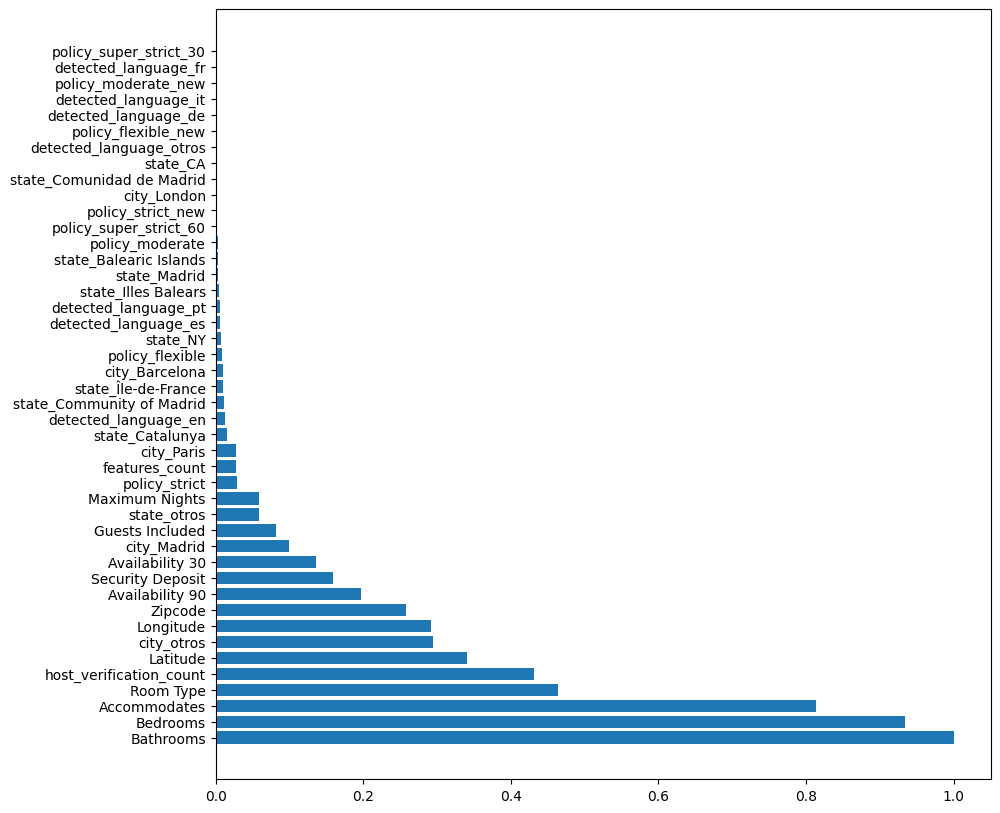

In [67]:
# Gráfica de la importancia de variables ordenada
importances = baggingModel.feature_importances_
importances = importances / np.max(importances)

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,10))
plt.barh(range(X_train.shape[1]),importances[indices])
plt.yticks(range(X_train.shape[1]),feature_names[indices])
plt.show()

In [68]:
# lanzaremos un segundo modelo pero sólo con las variables con más peso
columnas_especificas = ['Price',
    'Batchrooms',
    'Bedrooms',
    'Accomodates',
    'Room Type',
    'host_verification_count',
    'Latitude',
    'Longitude',
    'city_otros',
    'Zipcode',
    'Availability 90',
    'Availability 30',
    'Security Deposit',
    'city_Madrid',
    'Guests Included',
    'Maximum Nights',
    'state_otros',
    'policy_strict',
    'features_count',
    'city_Paris'
    # Agrega más nombres de columnas según sea necesario
]

indices = {'Price':0,
    'Batchrooms':1,
    'Bedrooms':2,
    'Accomodates':3,
    'Room Type':4,
    'host_verification_count':5,
    'Latitude':6,
    'Longitude':7,
    'city_otros':8,
    'Zipcode':9,
    'Availability 90':10,
    'Availability 30':11,
    'Security Deposit':12,
    'city_Madrid':13,
    'Guests Included':14,
    'Maximum Nights':15,
    'state_otros':16,
    'policy_strict':17,
    'features_count':18,
    'city_Paris':19,
    # Agrega más nombres de columnas según sea necesario
}


# Generamos nuevas arrays
print(f"Tipo de 'indices': {type(indices)}")
columnas_indices = [indices[col] for col in columnas_especificas if col in indices]
if not columnas_indices:
    raise ValueError("No se encontraron índices para las columnas especificadas.")
airbnb_train = airbnb_train[:, columnas_indices]

y_train = airbnb_train[:, 0]  
X_train = airbnb_train[:, 1:]   

airbnb_test = airbnb_test[:, columnas_indices]

# Definir y_test y X_test
y_test = airbnb_test[:, 0]
X_test = airbnb_test[:, 1:]

# Escalamos (con los datos de train)
scaler = preprocessing.StandardScaler().fit(X_train)
XtrainScaled = scaler.transform(X_train)

# Normalización
XtestScaled = scaler.transform(X_test)

print('Datos entrenamiento: ', XtrainScaled.shape)
print('Datos test: ', XtestScaled.shape)

Tipo de 'indices': <class 'dict'>
Datos entrenamiento:  (11260, 19)
Datos test:  (2814, 19)


In [69]:
# Como el objetivo es bajar sobreajuste y este modelo tendrá menos variables:
# bajamos rango de número de iteraciones, mantenemos learning rate y aumentamos depth para que el modelo, con menos variables,
# pueda ver relaciones más complejas..

Niterations = [50, 100, 200, 300]
learningRate = [0.01,0.05, 0.1]
max_depth = [3, 4, 5, 6]

param_grid = {'n_estimators': Niterations,'learning_rate':learningRate, 'max_depth':max_depth}
grid = GridSearchCV(GradientBoostingRegressor(random_state=0),
                    param_grid=param_grid,
                    scoring='neg_mean_squared_error',
                    cv = 3,
                    verbose=2)
grid.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

lrOptimo = grid.best_params_['learning_rate']
neOptimo = grid.best_params_['n_estimators']
mDepth = grid.best_params_['max_depth']
baggingModel = GradientBoostingRegressor(max_depth=mDepth, n_estimators=neOptimo, learning_rate=lrOptimo).fit(X_train,y_train)

print("Train: ",baggingModel.score(X_train,y_train))
print("Test: ",baggingModel.score(X_test,y_test))

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   1.0s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.9s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.9s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   1.9s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   1.9s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   1.9s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   4.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   4.2s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   4.2s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=300; total time=   6.4s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=300; total time=   6.6s
[CV] END ..learning_rate=0.01, max_depth=3, n_e

In [ ]:
# CONCLUSIÓN: El modelo empeora en el conjunto de entrenamiento pero se mantiene en el conjunto de test, esto podría ser
# un signo positivo de que se está logrando un mejor equilibrio entre ajuste y generalizacion.

# Posibles siguientes pasos a nivel modelo:
# Sería conveniente revisar y mejorar la limpieza de las variables para garantizar unos buenos datos al algoritmo
# Probar estudios con otros modelos
# revisar impacto de outliers

# Posibles siguientes pasos a nivel proyecto:
# Hay código que no está preparado para salir a produción (entre otros, los get dummies)
# Para facilitar la compensión podríamos guardar las funciones en otra hoja e importarlas